# PLANEJAMENTO DA SOLUÇÃO ( IOT )

## Input - Entrada

1. Problema de negócio
 - Selecionar os clientes mais valiosos para integrar um programa de fidelização
 
2. Conjunto de dados
 - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de fidelidade Insiders.
 
 - Lista: 
          client_id| is_insider |
             xxxxx | yes / 1
 
 - Relatório com as respostas das perguntas de negócio
 
     - Quem são as pessoas elegíveis para participar do programa insiders?

     - Quantos clientes farão parte do grupo?

     - Quais as principais características desse grupo?

     - Qual a porcentagem de contribuição do faturamento vinda desse grupo?

     - Qual a expectativa de faturamento desse grupo para os próximos meses?

     - Quais as condições para uma pessoa ser elegível ao insiders?

     - Quais as condições para uma pessoa ser removida do insiders?

     - Qual a garantia de que o programa insiders é melhor que o restante da base?

     - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa insiders?
    - O que é ser elegível? O que são os clientes de maior 'valor'?
    - Faturamento:
        - Alto ticket médio
        - Alto LTV
        - Baixa Recência
        - Alto Basket Size
        - Baixa probabilidade de Churn
        - Alta Previsão LTV
        - Alta Propensão de Compra
    
    - Custo:
        - Baixa taxa de devolução
    
    - Experiência de compra:
        - Média alta nas avaliações


2. Quantos clientes farão parte do grupo?
    - Numero total de clientes
    - a % do grupo insiders


3. Quais as principais características desse grupo?
    - Características dos clientes:
        - Idade
        - Localização
        - Renda
    - Características dos hábitos de consumo


4. Qual a porcentagem de contribuição do faturamento vinda desse grupo?
    - Calculo do faturamento total do ano
    - Calculo do faturamento do grupo insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort


6. Quais as condições para uma pessoa ser elegível ao insiders?
    - A pessoa precisa ser similar à uma pessoa do grupo
    - Definir periodicidade


7. Quais as condições para uma pessoa ser removida do insiders?
    - Definir periodicidade
    - Quando a pessoa se tornar dissimilar às outras do grupo


8. Qual a garantia de que o programa insiders é melhor que o restante da base?
    - Teste A/B
    - Teste de hipóteses
    - Teste A/B bayesiano


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Descontos
    - Preferencia de compra
    - fretes
    - visitas à empresa

## Benchmark de soluções

### RFM - Recency / Frequency / Monetary

# 0.0. IMPORTS

## 0.1. Libraries

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import plotly.express as px
import umap
import warnings

from datetime            import datetime
from matplotlib          import pyplot as plt
from IPython.display     import HTML
from pandas_profiling    import ProfileReport

from sklearn             import cluster as c
from sklearn             import metrics as mt
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble as en
from sklearn             import mixture as mx
from sklearn.manifold    import TSNE
from sklearn.neighbors   import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.2. Helper Functions

In [324]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('ggplot')
    plt.rcParams[ 'figure.figsize'] = [24,9]
    plt.rcParams[ 'font.size'] = 24
    
    display( HTML( '<style>.container {width:90% !important; } </style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    warnings.filterwarnings( 'ignore' )
    
    sns.set()

jupyter_settings()

## 0.3. Load Dataset

In [325]:
df = pd.read_csv( '../datasets/data.csv', encoding= 'unicode_escape')

# 1.0. DATA DESCRIPTIONS

In [326]:
df1 = df.copy()

## 1.1. Rename Columns


In [327]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = new_cols

## 1.2. Data Dimension


In [328]:
print( f'Number of columns: {df1.shape[1]}' )
print( f'Number of rows: {df1.shape[0]}' )

Number of columns: 8
Number of rows: 541909


## 1.3. Data Types


In [329]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA


In [330]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA


In [331]:
df_missing = df1.loc[ df1['customer_id'].isna() , :]
df_not_missing = df1.loc[ ~df1['customer_id'].isna() , :]

In [332]:
# pegar todos invoice_no unicos do df_missing 
df_backup = pd.DataFrame( df_missing['invoice_no'] ).drop_duplicates()

# atribuir para o customer_id um numero acima do maximo existente no dataset completo (18287)
df_backup['customer_id_new'] = np.arange( 19000, len( df_backup) + 19000, 1)

# juntar df_backup com o dataset original
df1 = pd.merge( df1, df_backup, how='left', on='invoice_no' )

# coalesce
df1['customer_id'] = df1['customer_id'].combine_first( df1['customer_id_new'] )

# excluir coluna extra
df1 = df1.drop( columns = ['customer_id_new'] )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [333]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6. Change Data Types


In [334]:
df1['invoice_date'] = df1['invoice_date'].apply( lambda x: re.search('(\d.+) ', x).group(1) )

df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [335]:
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [336]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics


In [337]:
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes


In [338]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.mean() ).T
ct2 = pd.DataFrame( num_attributes.median() ).T

# dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d4 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1. Numerical Attribbutes - Investigating


1. Quantidade negativa ( pode ser devolução )


2. Preço unitário negativo

### 1.7.2. Categorical Attributes


#### Invoices

In [339]:
# invoice_no with strings
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^\d]+', x) ) ), 'invoice_no'].drop_duplicates() ) 

3839

#### Stock Code

In [340]:
# stock_code with only### Invoices strings
cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()

# Action:
# Remove all lines with ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Descriptions

In [341]:
# Delete Descriptions

#### Country

In [342]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [343]:
cat_attributes['country'].value_counts( normalize= True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [344]:
# Quantity of customers by country
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending= False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. FEATURE FILTERING

In [345]:
df2 = df1.copy()

In [346]:
# === numerical attributes ===
df2 = df2.loc[ df2['unit_price'] >= 0.04, :]

# === Categorical attributes ===
df2[ ~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns= 'description', axis=1 )

# map
df2 = df2[ ~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[ ~df2['customer_id'].isin( [16446] ) ]

# quantity
df2_returns = df2.loc[ df2['quantity'] < 0, : ]
df2_purchase = df2.loc[ df2['quantity'] >= 0, : ]

# 3.0. FEATURE ENGINNERING

In [347]:
df3 = df2.copy()
df3_purchase = df2_purchase.copy()
df3_returns = df2_returns.copy()

In [348]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'] , axis=1).drop_duplicates( ignore_index = True )

In [349]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 3.1. Gross Revenue

In [350]:
# gross revenue ( faturamento ) = quantity * price
df3_purchase['gross_revenue'] = df3_purchase['quantity'] * df3_purchase['unit_price']

# monetary
df_monetary = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id        0
gross_revenue    215
dtype: int64

## 3.2. Recency

In [351]:
# recency - Last day purchase
df_recency = df3_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how = 'left', on='customer_id')
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
dtype: int64

## 3.3. Quantity of Invoices

In [352]:
# quantity
df_quant = ( df3_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
                                                                                                 .rename( columns= {'invoice_no': 'qty_invoices'} ) )
df_ref = pd.merge( df_ref, df_quant, how= 'left', on = 'customer_id' )
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
qty_invoices     215
dtype: int64

## 3.4. Average Ticket

In [353]:
# Average Ticket
df_avg_ticket = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns= {'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, how = 'left', on='customer_id')
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
qty_invoices     215
avg_ticket       215
dtype: int64

## 3.5. Average Recency Days

In [354]:
# average recency days
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending= [False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['next_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = ( df_aux.apply( lambda x: (x['next_date'] - x['invoice_date']).days if 
                                                        x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 ) )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'next_date'], axis=1).dropna()

# average recency days
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days         215
qty_invoices         215
avg_ticket           215
avg_recency_days    2984
dtype: int64

## 3.6. Frequency Purchase

In [355]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                      .agg( max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_ = ('invoice_date', lambda x: ( ( x.max() - x.min() ).days ) +1 ),
                                                                           buy_ = ('invoice_no', 'count') ).reset_index() )

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days         215
qty_invoices         215
avg_ticket           215
avg_recency_days    2984
frequency            215
dtype: int64

## 3.7. Number of Returns

In [356]:
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns = {'quantity': 'qty_returns'})

df_returns['qty_returns'] = df_returns['qty_returns'] * (-1)

df_ref = pd.merge( df_ref, df_returns, how= 'left', on='customer_id')
df_ref.loc[ df_ref['qty_returns'].isna() , 'qty_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days         215
qty_invoices         215
avg_ticket           215
avg_recency_days    2984
frequency            215
qty_returns            0
dtype: int64

## 3.8. Basket Size - Quantity of Itens by basket

In [357]:
df_aux = ( df3_purchase[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                  .agg( n_purchase = ('invoice_no', 'nunique'),
                                                                        n_products = ('quantity', 'sum') ).reset_index() )
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how= 'left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days         215
qty_invoices         215
avg_ticket           215
avg_recency_days    2984
frequency            215
qty_returns            0
avg_basket_size      215
dtype: int64

## 3.9. Unique Basket Size - Quantity of Itens

In [358]:
df_aux = ( df3_purchase[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                    .agg( n_purchase = ('invoice_no', 'nunique'),
                                                                          n_products = ('stock_code', 'nunique') ).reset_index() )
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how= 'left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue              215
recency_days               215
qty_invoices               215
avg_ticket                 215
avg_recency_days          2984
frequency                  215
qty_returns                  0
avg_basket_size            215
avg_unique_basket_size     215
dtype: int64

## 3.10. Quantity of Itens

In [359]:
# quantity
df_quant_prod = df3_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns = {'quantity': 'qty_itens'})
df_ref = pd.merge( df_ref, df_quant_prod, how= 'left', on = 'customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue              215
recency_days               215
qty_invoices               215
avg_ticket                 215
avg_recency_days          2984
frequency                  215
qty_returns                  0
avg_basket_size            215
avg_unique_basket_size     215
qty_itens                  215
dtype: int64

## 3.11. Quantity of Products


In [360]:
# quantity
df_quant_prod = df3_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename( columns = {'stock_code': 'qty_products'})
df_ref = pd.merge( df_ref, df_quant_prod, how= 'left', on = 'customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue              215
recency_days               215
qty_invoices               215
avg_ticket                 215
avg_recency_days          2984
frequency                  215
qty_returns                  0
avg_basket_size            215
avg_unique_basket_size     215
qty_itens                  215
qty_products               215
dtype: int64

# 4.0. EDA - EXPLORATORY DATA ANALYSIS 

In [361]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qty_returns               0
avg_basket_size           0
avg_unique_basket_size    0
qty_itens                 0
qty_products              0
dtype: int64

In [369]:
df_ref.shape

(5970, 12)

## 4.1. Univariate Analysis 

**Métricas para Olharmos!**

    1. Clusters Coesos - Separados
    2. Métricas:
        - Min, Max, Range (Dispersão)
        - Média e Mediana
        - Desvio Padrão e Variancia
        - Coeficiente de Variação (CV)
        - Distribuição

**Anatações / Investigação**

    1. Gross Revenue - OK
    2. Recency Days - OK
    3. Qty Itens - Customer_id 14646, possui muitos itens comprados, porém está coerente
    4. Avg_ticket - Customer_id 16446, possui alto avg_ticket, porém com apenas 3 invoices. Fez 2 compras e devolveu tudo (remover da base)

In [362]:
# profile = ProfileReport( df4 )
# profile.to_file( 'output_v2.html' )

### 4.1.1 Gross Revenue 

In [363]:
df4.sort_values('gross_revenue', ascending= False).head()

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products
1031,14646,280206.02,1.0,73.0,134.973998,7.673913,0.206215,772.0,2697.465753,9.589041,196915.0,2076.0
504,18102,259657.30,0.0,60.0,602.453132,14.115385,0.163043,2.0,1068.733333,2.500000,64124.0,431.0
433,17450,194550.79,8.0,46.0,577.302047,11.218750,0.127778,964.0,1521.586957,2.695652,69993.0,337.0
67,14911,143825.06,1.0,201.0,25.343623,2.565517,0.538874,3335.0,399.328358,8.890547,80265.0,5675.0
1168,12415,124914.53,24.0,21.0,174.950322,18.411765,0.066879,428.0,3684.476190,21.142857,77374.0,714.0


### 4.1.2 Qty Itens

In [42]:
df4.loc[ df4['qty_itens'] == 196915 ]

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products
1031,14646,280206.02,1.0,73.0,134.973998,7.673913,0.206215,772.0,2697.465753,9.589041,196915.0,2076.0


In [43]:
df3.loc[ df3['customer_id'] == 14646 ].sort_values('quantity', ascending=False).head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
421601,573003,23084,2400,2011-10-27,2.08,14646,Netherlands
409248,572052,22595,1728,2011-10-20,0.72,14646,Netherlands
63444,541570,21212,1440,2011-01-19,0.42,14646,Netherlands
534952,581175,23084,1440,2011-12-07,1.79,14646,Netherlands
186820,552883,21212,1200,2011-05-12,0.42,14646,Netherlands
204198,554642,22243,960,2011-05-25,1.45,14646,Netherlands
137026,548011,22629,640,2011-03-29,1.65,14646,Netherlands
137027,548011,22630,640,2011-03-29,1.65,14646,Netherlands
454094,575510,22492,576,2011-11-10,0.55,14646,Netherlands
408892,572035,22492,576,2011-10-20,0.55,14646,Netherlands


### 4.1.3 Avg Ticket

In [44]:
df4.loc[ df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products


In [45]:
df3.loc[ df3['customer_id'] == 16446 ]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country


### 4.1.4. Frequency

In [46]:
df4.loc[ df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products
0,17850,5391.21,372.0,34.0,18.152222,35.5,17.0,40.0,50.970588,0.617647,1733.0,297.0


In [47]:
df3.loc[ df3['customer_id'] == 17850].head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,8,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,6,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,6,2010-12-01,3.39,17850,United Kingdom
5,536365,22752,2,2010-12-01,7.65,17850,United Kingdom
6,536365,21730,6,2010-12-01,4.25,17850,United Kingdom
7,536366,22633,6,2010-12-01,1.85,17850,United Kingdom
8,536366,22632,6,2010-12-01,1.85,17850,United Kingdom
47,536372,22632,6,2010-12-01,1.85,17850,United Kingdom


### 4.1.5. Qty_returns

In [48]:
df4.loc[ df4['qty_returns'] == 80995]

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products


In [49]:
df3.loc[ df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country


### 4.1.6. Avg_basket_size

In [50]:
df4.loc[ df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qty_invoices,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size,qty_itens,qty_products


## 4.2. Bivariate Analysis 

In [51]:
# Deletar variável customer_id
df4_2 = df4.drop( ['customer_id'], axis = 1 )

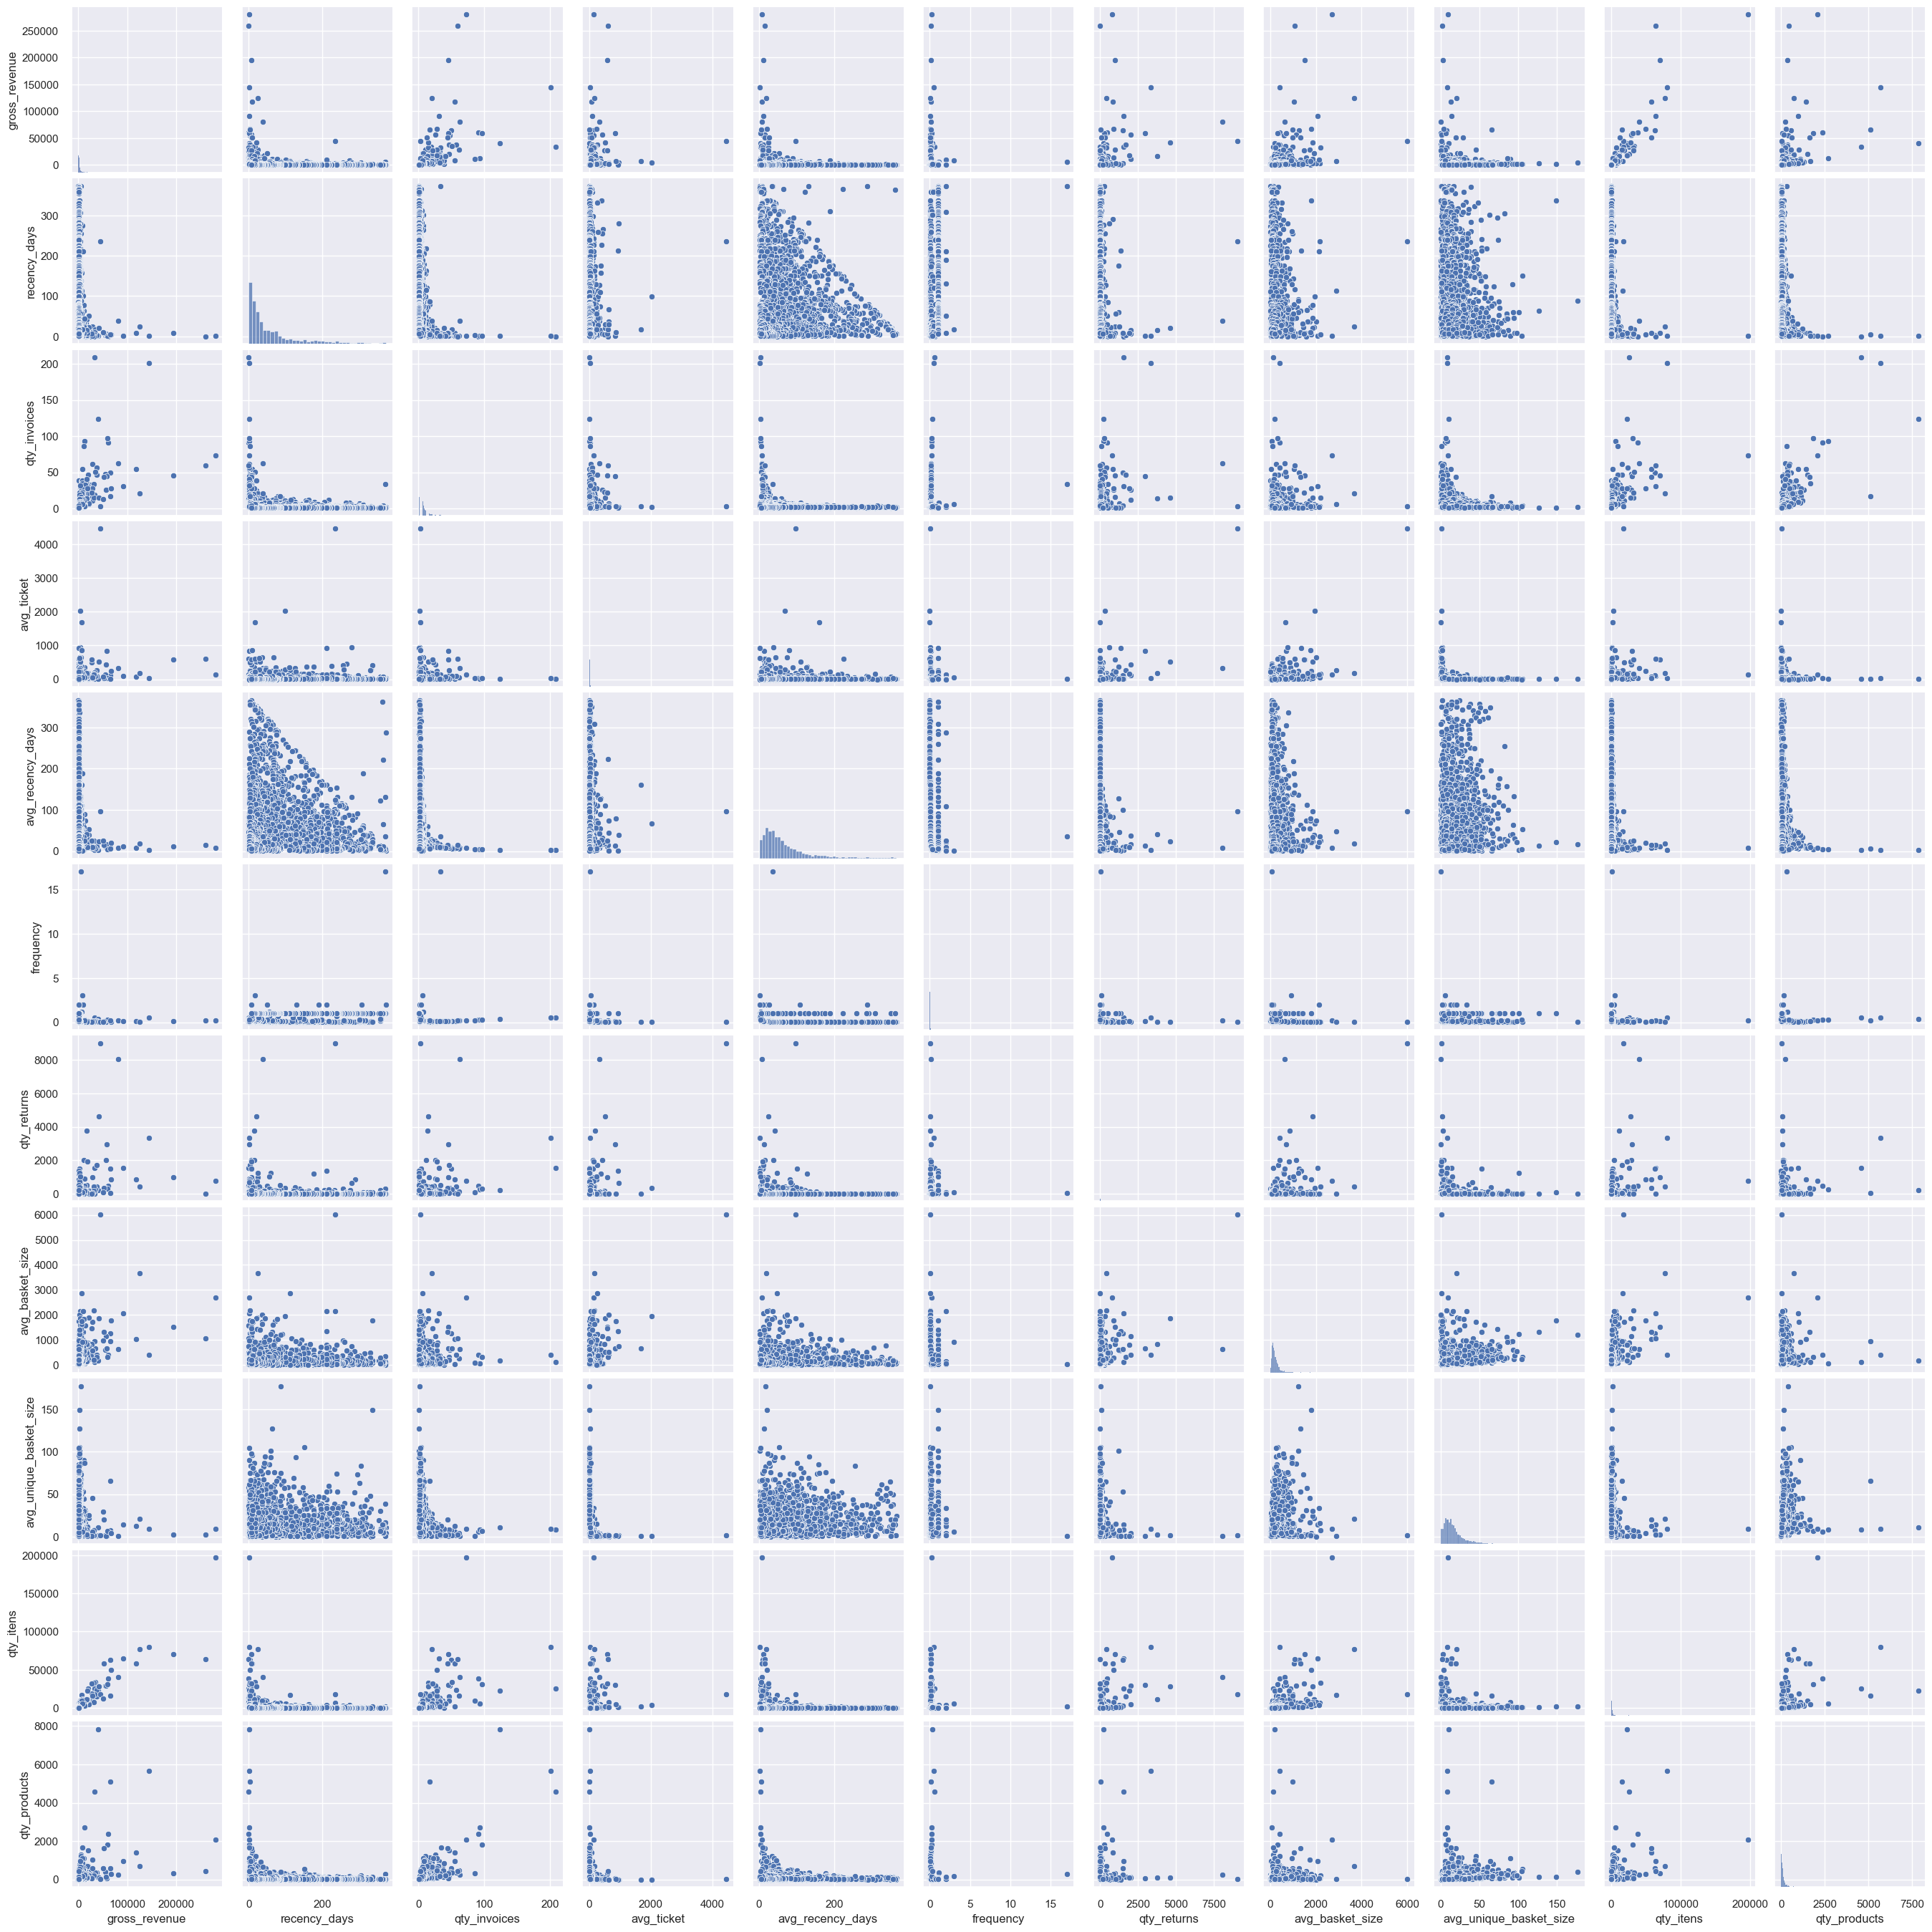

In [52]:
sns.pairplot( df4_2);

**Notes**
1. Frequency - Pouca variabilidade
2. Avg_ticket - Pouca variação
3. Qty_itens / Qty_products / Qty_invoices - Variação similar

## 4.3. Space Study

In [364]:
# original dataset
# df4_3 = df4.drop( columns= ['customer_id'], axis=1).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']
df4_3 = df4.copy()
df4_3 = df4_3[cols_selected].copy()

In [365]:
# normalizar os dados
mm = pp.MinMaxScaler()

df4_3['gross_revenue']          = mm.fit_transform( df4_3[['gross_revenue']] )
df4_3['recency_days']           = mm.fit_transform( df4_3[['recency_days']] )
# df4_3['qty_invoices']           = mm.fit_transform( df4_3[['qty_invoices']] )
# df4_3['avg_ticket']             = mm.fit_transform( df4_3[['avg_ticket']] )
# df4_3['avg_recency_days']       = mm.fit_transform( df4_3[['avg_recency_days']] )
df4_3['frequency']              = mm.fit_transform( df4_3[['frequency']] )
df4_3['qty_returns']            = mm.fit_transform( df4_3[['qty_returns']] )
# df4_3['avg_basket_size']        = mm.fit_transform( df4_3[['avg_basket_size']] )
# df4_3['avg_unique_basket_size'] = mm.fit_transform( df4_3[['avg_unique_basket_size']] )
# df4_3['qty_itens']              = mm.fit_transform( df4_3[['qty_itens']] )
df4_3['qty_products']           = mm.fit_transform( df4_3[['qty_products']] )

X = df4_3.copy()

In [367]:
X.shape

(2984, 6)

### 4.3.1. PCA

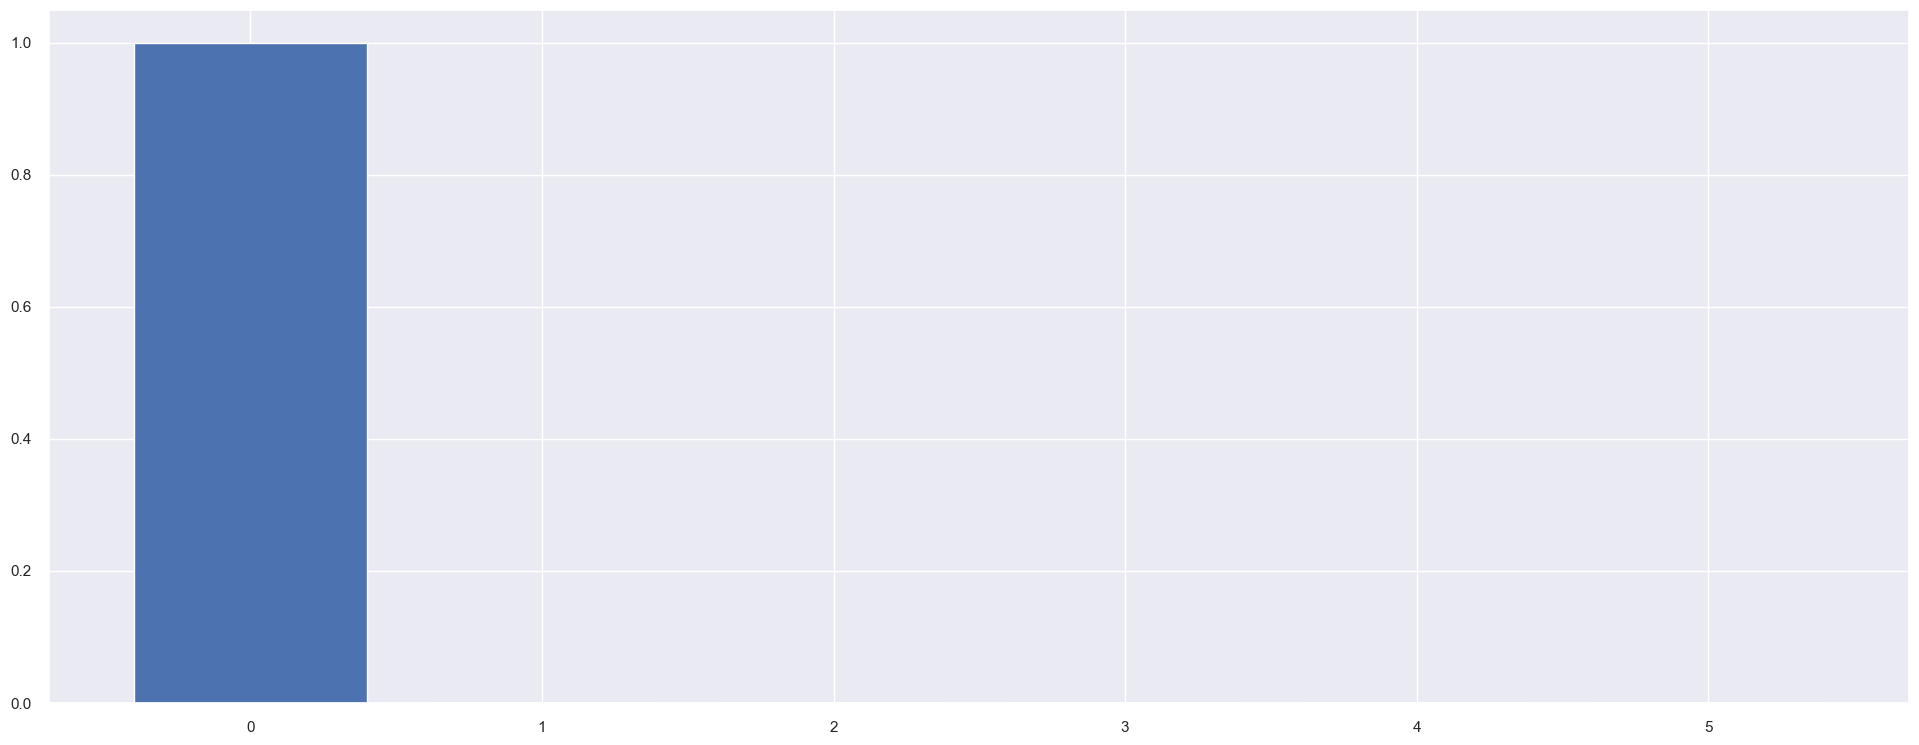

In [147]:
pca = dd.PCA( n_components= X.shape[1])

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( x= features, height = pca.explained_variance_ratio_ );

# PCA component
df_pca = pd.DataFrame( principal_components )

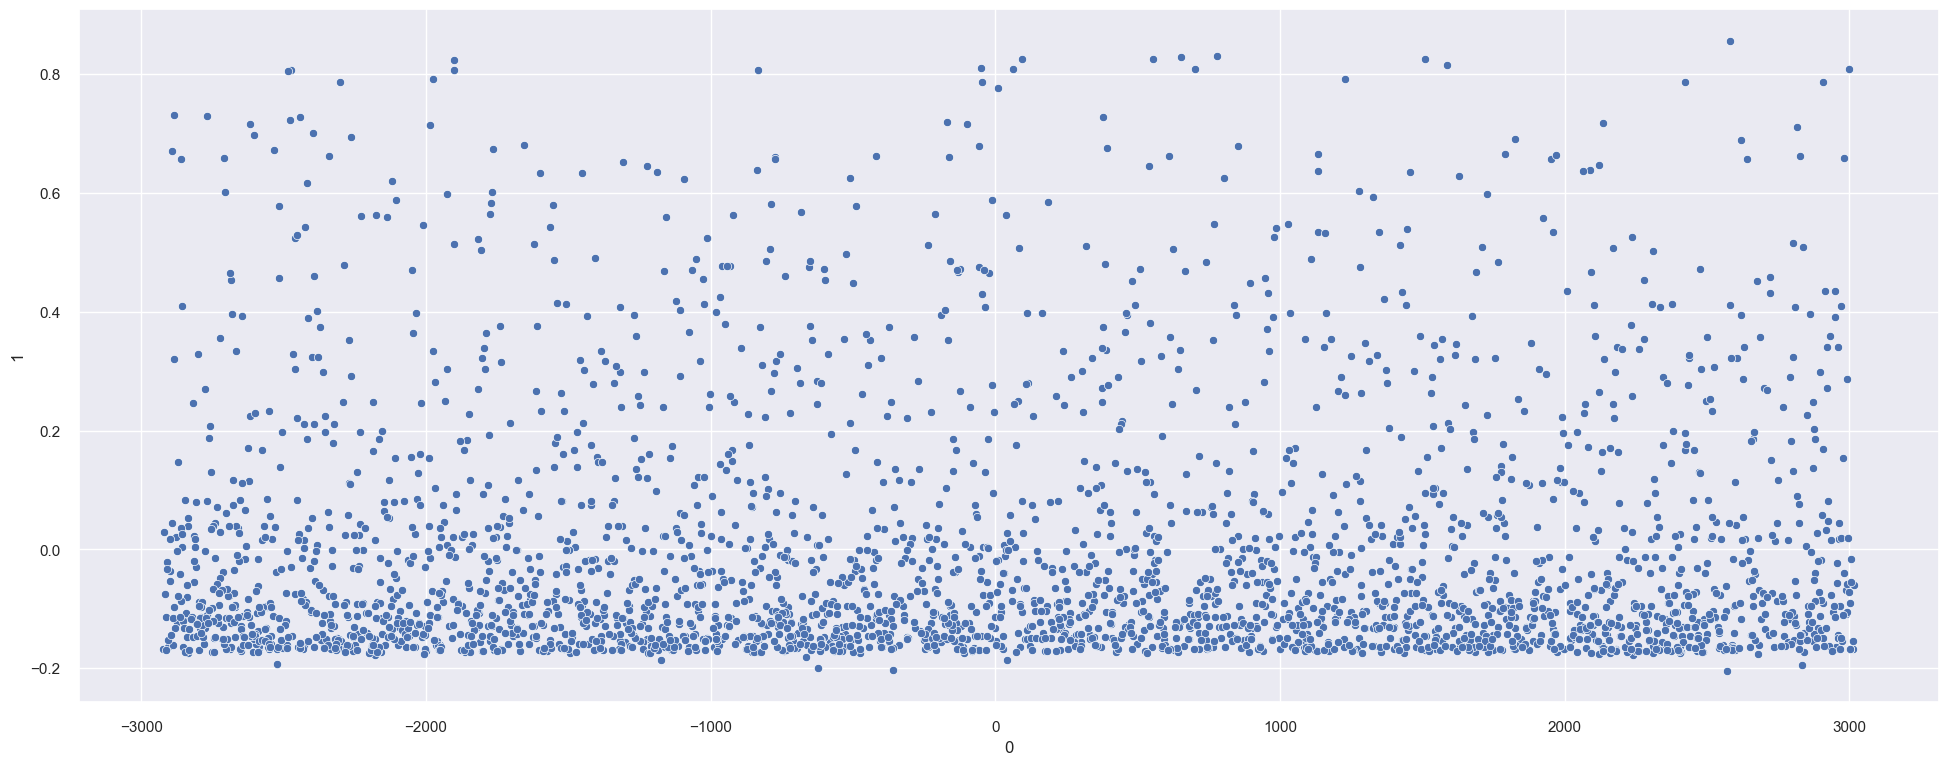

In [148]:
sns.scatterplot( x=0, y=1, data = df_pca);

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

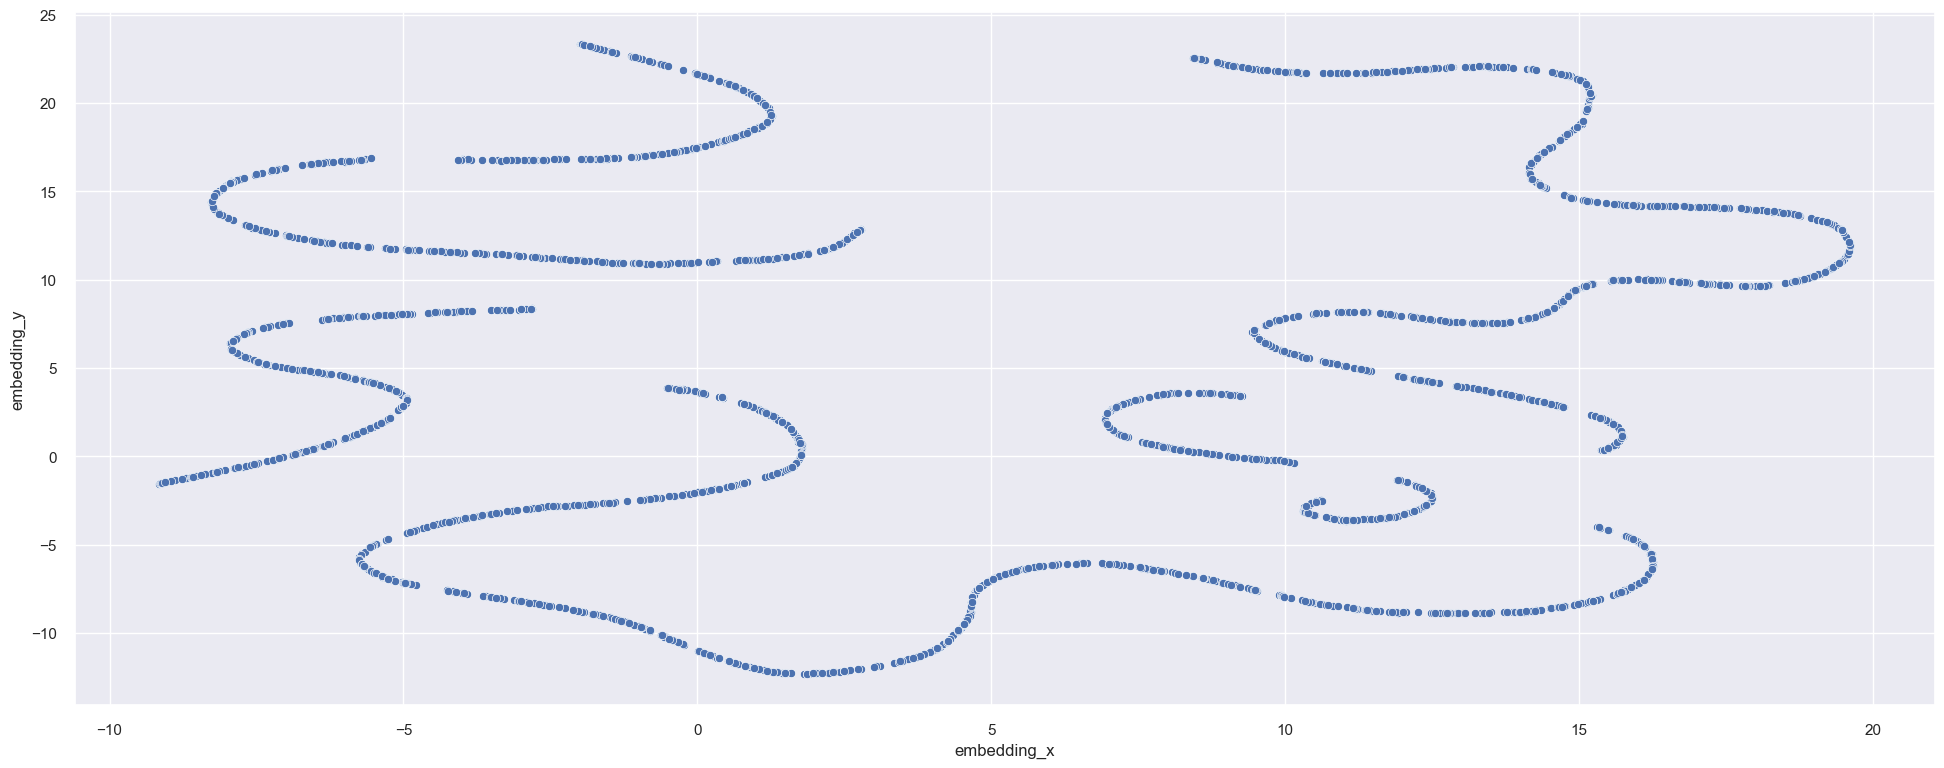

In [149]:
reducer = umap.UMAP( random_state = 42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data= df_pca )

### 4.3.3. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

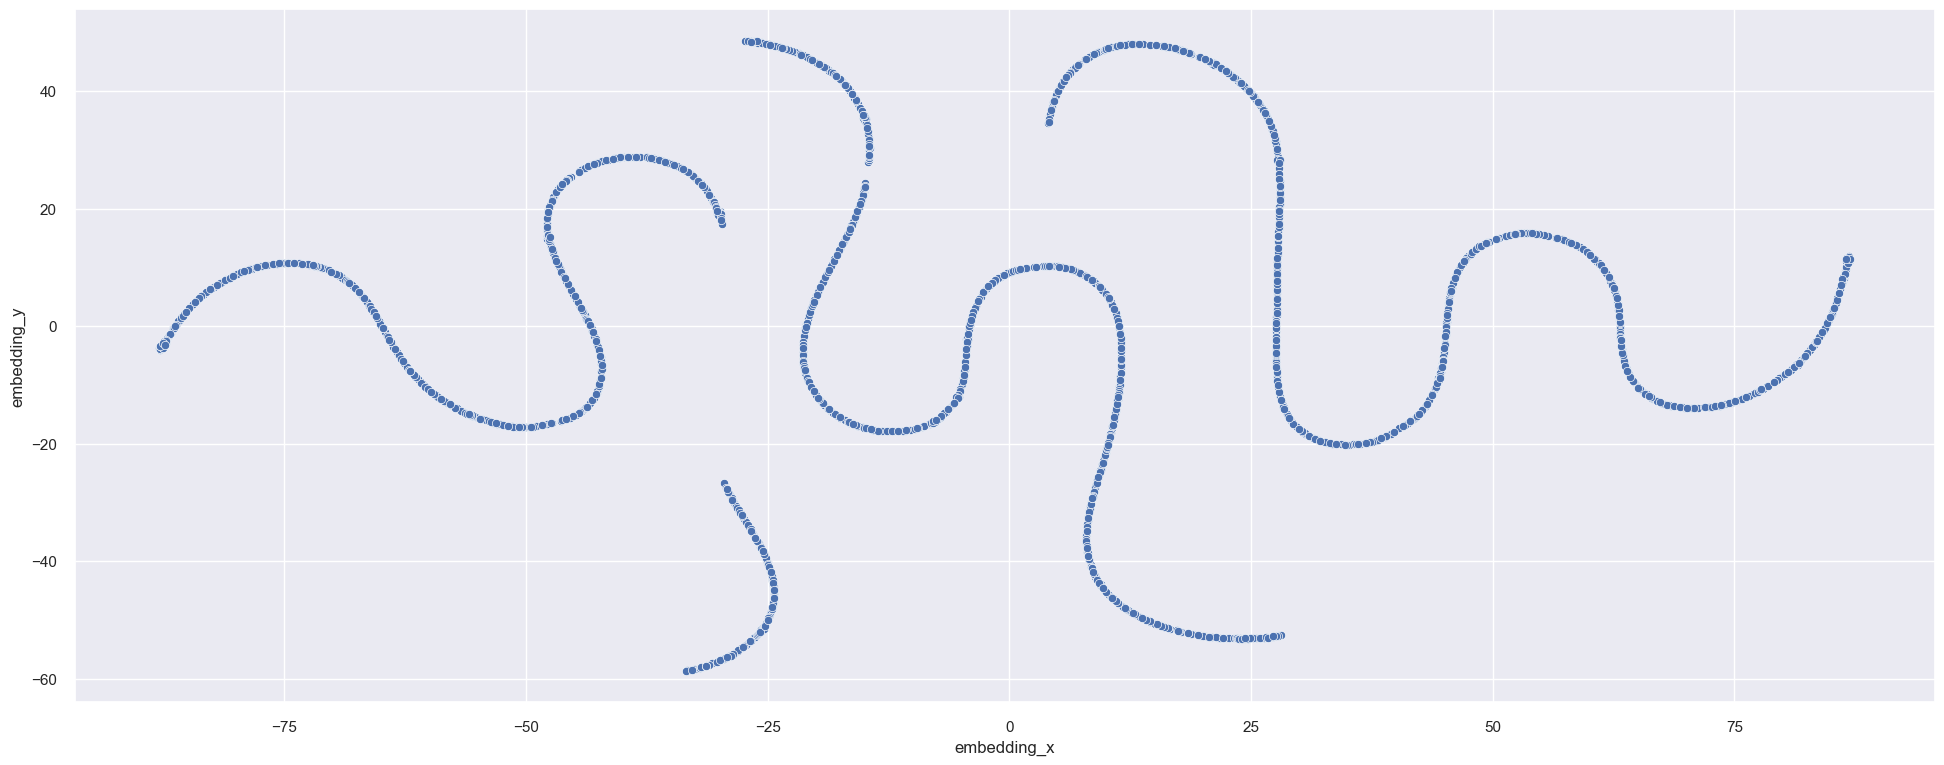

In [150]:
reducer = TSNE( n_components= 2, n_jobs= -1, random_state = 42)
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot TSNE
sns.scatterplot( x='embedding_x', y='embedding_y', data= df_pca )

### 4.3.4. Tree-Based Embedding

In [151]:
# Training Dataset
X = df4_3.drop( columns = ['customer_id', 'gross_revenue'], axis=1 )
y = df4_3['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

RandomForestRegressor(random_state=42)

In [152]:
# Leaf
df_leaf =  pd.DataFrame( rf_model.apply( X ) )

In [153]:
# Dataframe Leaf
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3759,3517,3567,3507,3600,3588,3417,3480,3485,3620,3615,3518,3571,3789,3506,3503,3731,3674,3493,3469,3561,3729,3495,3687,3503,3451,3587,3461,3382,3728,3490,3755,3617,3741,3708,3727,3408,3373,3661,3423,3729,3612,3542,3471,3601,3505,3653,3452,3637,3680,3606,3703,3556,3706,3549,3607,3639,3601,3392,3719,3516,3663,3511,3628,3526,3538,3606,3598,3577,3561,3740,3536,3616,3586,3532,3665,3612,3552,3677,3390,3627,3568,3476,3666,3557,3708,3460,3771,3574,3672,3443,3432,3707,3584,3661,3624,3478,3664,3682,3765
1,2985,3385,3356,3505,3042,3477,3287,3389,3254,3402,3542,2940,3138,3236,3402,3398,3256,3459,3320,3225,3483,3590,3030,2837,3345,3302,3145,3410,3286,3030,3455,3031,3067,3069,3289,3261,3280,3029,3183,3223,3519,3104,3391,3248,3095,3274,3145,3353,3316,3059,3149,3365,3418,3082,3441,3145,3012,3451,3211,3173,3361,3062,3373,3530,3416,3228,3404,3061,3361,3009,3076,3394,2908,3161,3384,3213,3199,3470,3498,3240,3034,3383,3118,3319,3382,3298,3133,3213,3375,3222,3246,3331,3106,2994,3503,3106,3282,3126,3183,3545
2,3699,3541,3503,3455,3443,3529,3494,3492,3480,3640,3564,3477,3518,3260,3437,3452,3353,3551,3368,3522,3489,3644,3458,3594,3556,3520,3513,3494,3375,3647,3464,3688,3541,3635,3336,3345,3350,3429,3260,3403,3613,3628,3459,3372,3456,3387,3563,3526,3610,3602,3598,3370,3613,3623,3503,3519,3601,3477,3312,3633,3461,3556,3415,3551,3365,3657,3651,3599,3404,3512,3630,3476,3634,3577,3513,3318,3649,3520,3531,3399,3552,3404,3320,3348,3432,3409,3181,3695,3530,3263,3406,3478,3633,3621,3587,3550,3567,3634,3635,3528
3,1231,980,492,290,372,1592,352,563,1096,402,343,689,1187,970,1025,781,299,317,1217,531,1219,513,333,1161,327,702,898,768,806,304,380,933,346,563,1129,818,791,1641,882,1140,358,397,536,1073,300,1345,1319,361,960,377,306,1197,383,534,1365,1341,317,995,565,1046,1377,587,346,667,1215,452,309,382,387,1131,1190,985,799,272,956,646,723,711,332,530,313,522,592,363,646,483,939,667,319,1365,940,344,214,650,798,1289,1186,490,959,1061
4,490,453,686,1173,745,495,687,691,579,762,607,73,682,576,451,353,39,767,493,786,643,714,635,498,742,1066,57,349,539,713,753,527,663,108,376,434,1066,756,1383,576,566,669,121,41,686,392,486,570,107,629,744,498,746,832,510,520,695,132,1059,140,482,129,706,345,58,1141,712,688,665,527,66,445,660,1140,462,1050,968,345,663,598,925,821,1103,533,495,76,334,984,1031,413,626,710,378,809,348,491,439,690,463,525


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

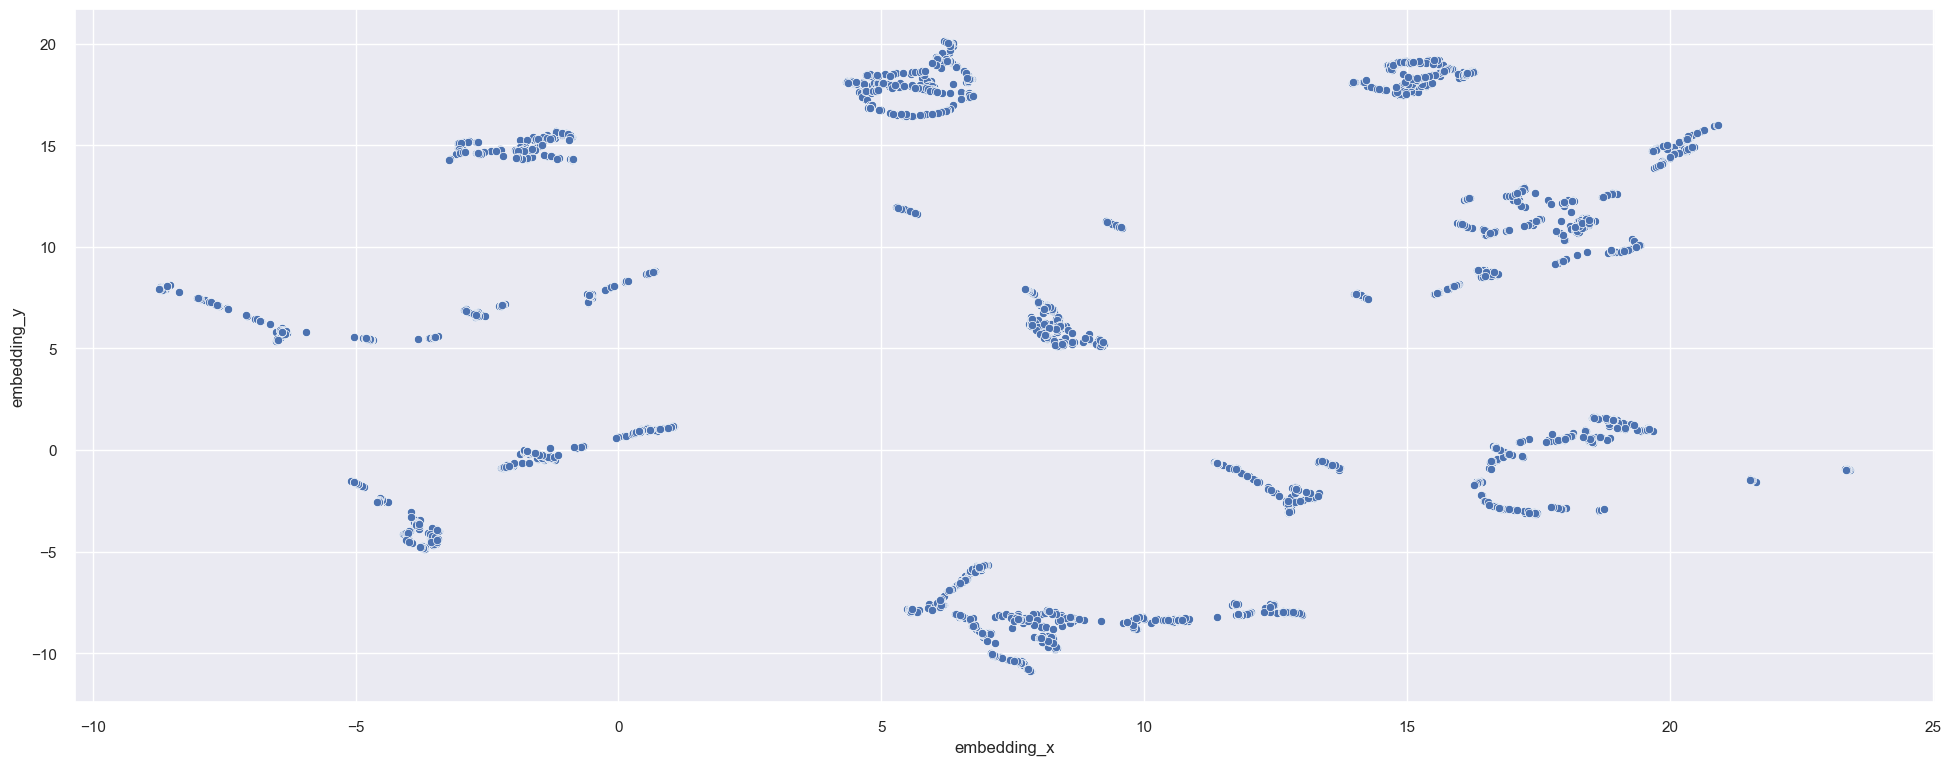

In [154]:
# reducer dimensionality
reducer = umap.UMAP( random_state = 42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data= df_tree )

# 5.0. DATA PREPARATION

**Regra para padronização / rescala**
1. Distribuição Normal e não possui outlier -> Standard Scaler ( média e desvio padrão )
2. Distribuição Normal e possui outlier -> Robust Scaler ( Quartis )
3. Distribuição não Normal -> Min Max Scaler

**Testes de Normalidade**

QQ plot - Quantile Quantile Plot

kS Teste - Kolgomorov Smirnoff (Teste de Hipótese) - Se p-value > 0.05 = Distribuição Normal, Se p-value < 0.05 = Distribuição Não Normal

**Detecção de Outliers**

Box Plot (visual) - Pontos são identificados como outliers

IRQ * 1.5 - Acima desse valor são outliers

Z-Score > 3 -> Outliers
Z-Score < -3 -> Outliers

In [155]:
# df5 = df4.copy()
df5 = df_tree.copy()

In [156]:
# # Standard Scaler
# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

# df5['gross_revenue']          = mm.fit_transform( df5[['gross_revenue']] )
# df5['recency_days']           = mm.fit_transform( df5[['recency_days']] )
# # df5['qty_invoices']           = mm.fit_transform( df5[['qty_invoices']] )
# # df5['avg_ticket']             = mm.fit_transform( df5[['avg_ticket']] )
# # df5['avg_recency_days']       = mm.fit_transform( df5[['avg_recency_days']] )
# df5['frequency']              = mm.fit_transform( df5[['frequency']] )
# df5['qty_returns']            = mm.fit_transform( df5[['qty_returns']] )
# # df5['avg_basket_size']        = mm.fit_transform( df5[['avg_basket_size']] )
# # df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )
# # df5['qty_itens']              = mm.fit_transform( df5[['qty_itens']] )
# df5['qty_products']           = mm.fit_transform( df5[['qty_products']] )

# 6.0. FEATURE SELECTIONS

In [157]:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']

In [158]:
# df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7.0. HYPERPARAMETER FINE-TUNING

In [159]:
# X = df6.drop( columns= ['customer_id'] )
X = df_tree.copy()

In [160]:
X.head()

,embedding_x,embedding_y
0,7.000337,-9.016847
1,12.766449,-2.516786
2,7.157575,-9.472236
3,-1.607520,15.264236
4,-6.623262,6.195890


In [161]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange( 2, 26, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

## 7.1. K-Means

In [162]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

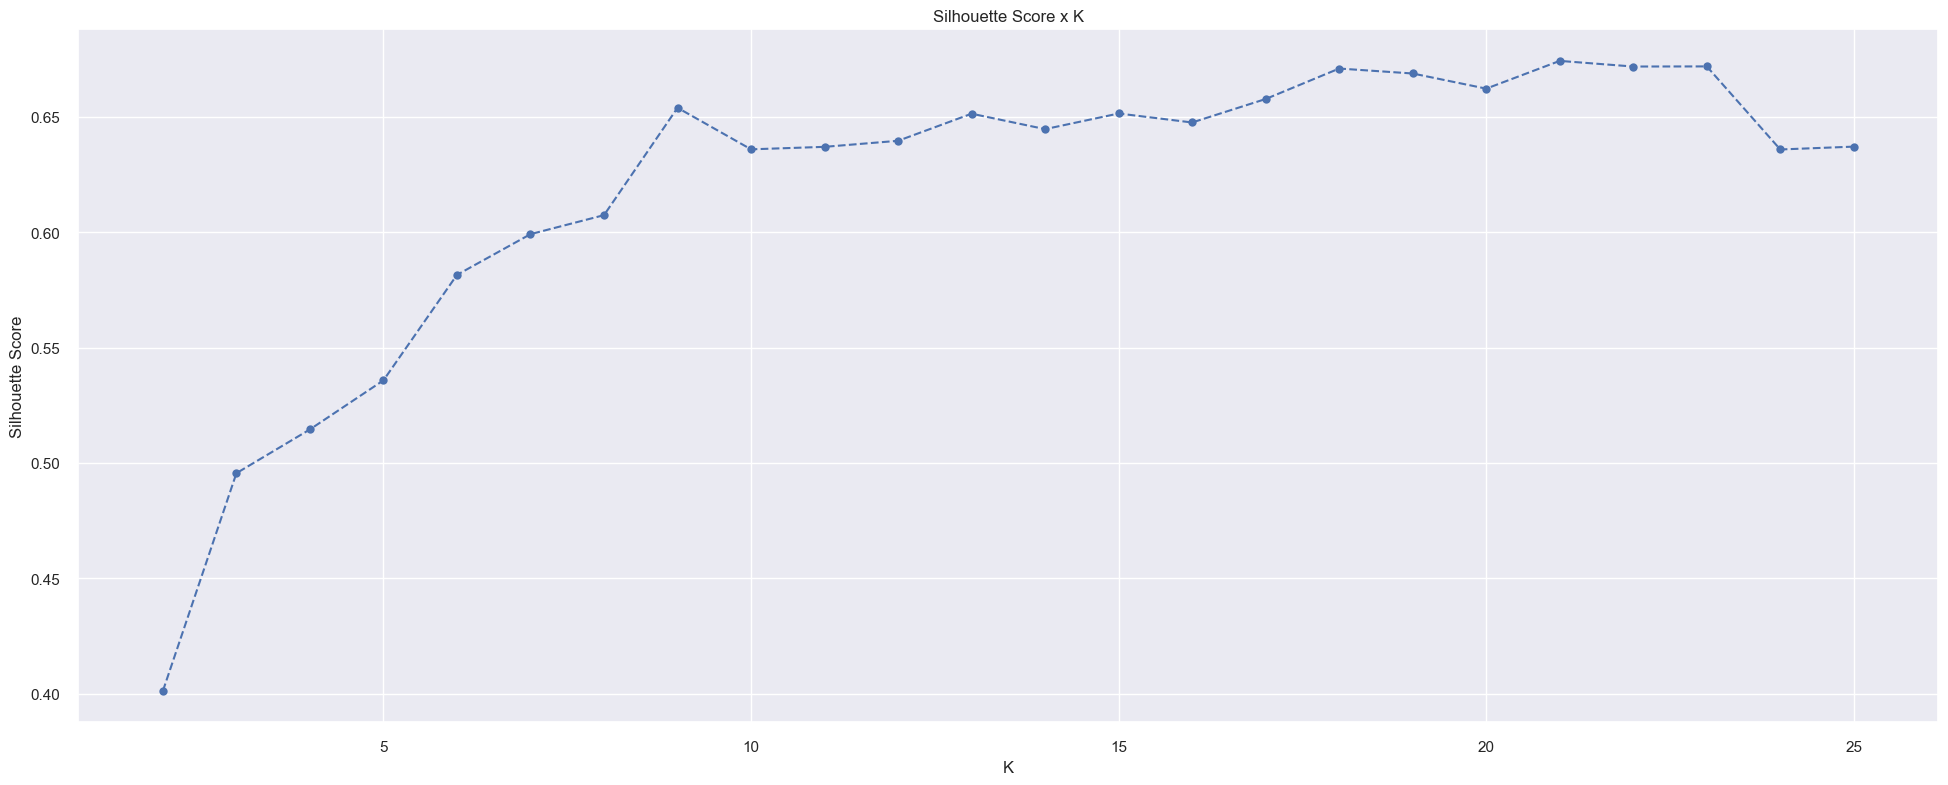

In [163]:
plt.plot( clusters, kmeans_list, linestyle= '--', marker='o', color='b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K');

## 7.2. GMM

In [164]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components= k)

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric= 'euclidean' )
    gmm_list.append( sil )

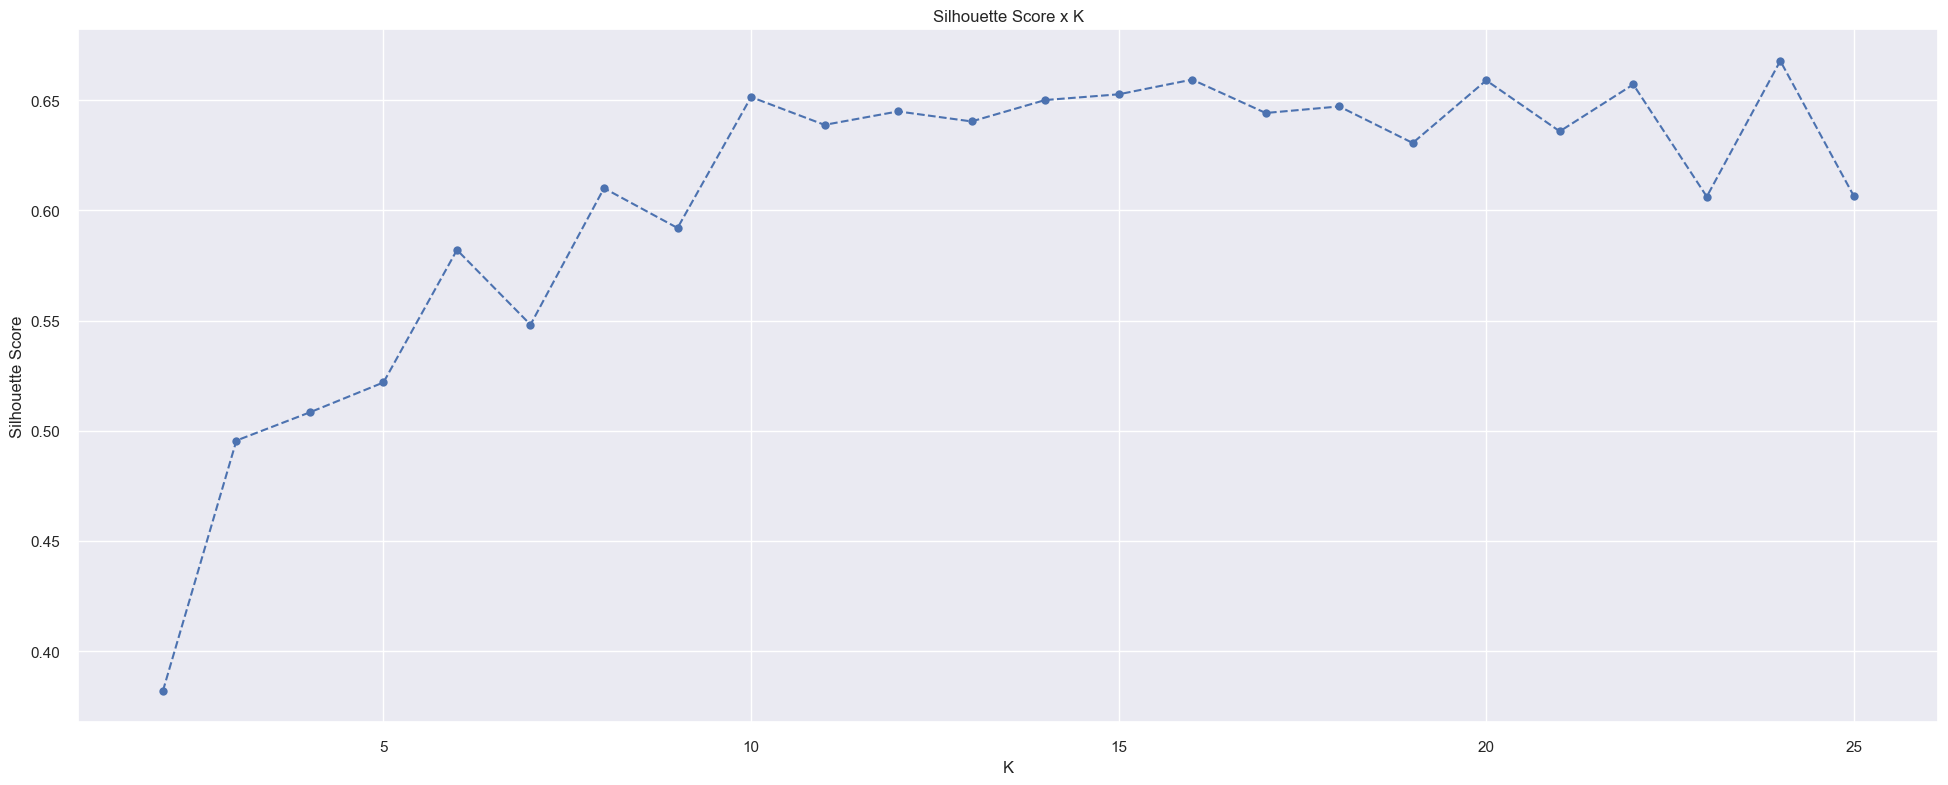

In [165]:
plt.plot( clusters, gmm_list, linestyle='--', marker= 'o', color='b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K');

## 7.3. Hierarchical Clustering


In [166]:
from scipy.cluster import hierarchy as hc

In [167]:
# model definition and training
hc_model = hc.linkage( X, method= 'ward', metric= 'euclidean')

In [168]:
# hc.dendrogram( hc_model, leaf_rotation=90, leaf_font_size=8 )
# plt.plot()

In [169]:
# hc.dendrogram( hc_model, truncate_mode= 'lastp', p=12, leaf_rotation= 90, leaf_font_size= 12, show_contracted= True )
# plt.show()

### 7.3.1 Hierarchical Clustering Silhouette Score

In [170]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage( X, method='ward')
    
    # model predict
    labels = hc.fcluster( hc_model, k, criterion= 'maxclust' )
    
    # model performance
    sil = mt.silhouette_score( X, labels, metric= 'euclidean')
    hc_list.append( sil )

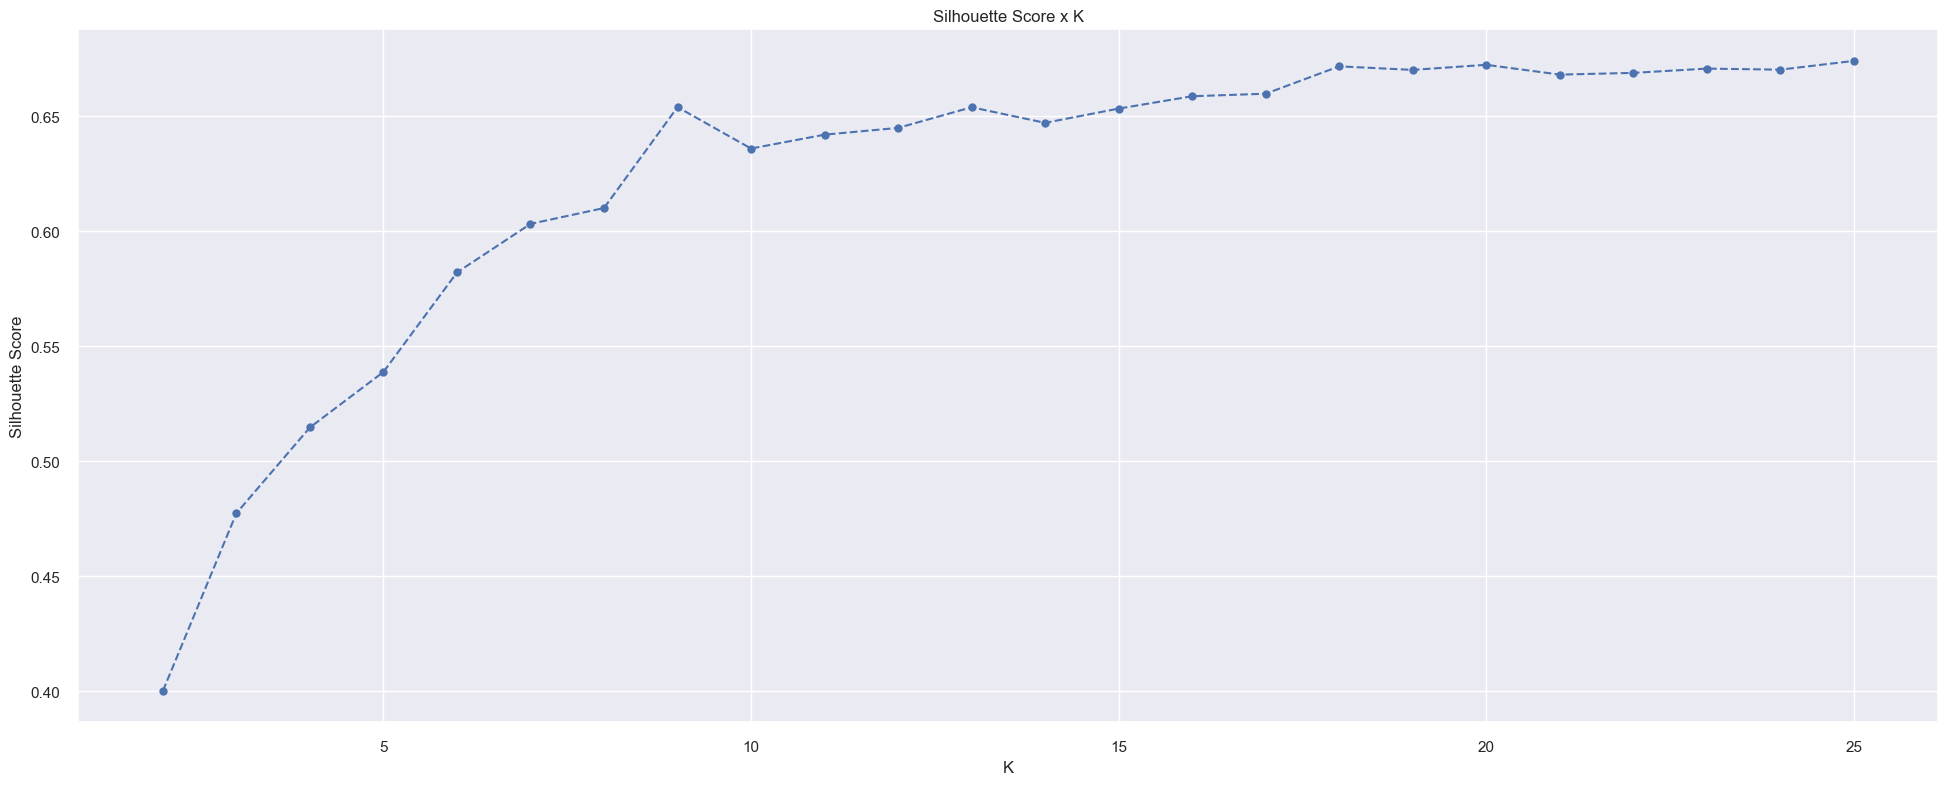

In [171]:
plt.plot( clusters, hc_list, linestyle= '--', marker= 'o', color= 'b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.4. DBSCAN

In [172]:
eps= 2.0
min_samples= 20

# model definition
dbscan_model = c.DBSCAN( eps= eps, min_samples= min_samples )

# model training and predict
labels = dbscan_model.fit_predict( X )

# model performance
sil = mt.silhouette_score( X, labels, metric= 'euclidean' )
print( f'Silhouette Score: {sil}')
print( f'Number of Clusters: { len( np.unique( labels ) ) }' )
print( np.unique( labels ) )

Silhouette Score: 0.6432543396949768
Number of Clusters: 14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [173]:
neighbors = NearestNeighbors( n_neighbors= min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

distances = np.sort( distances, axis= 0 )
distances = distances[:, 1]

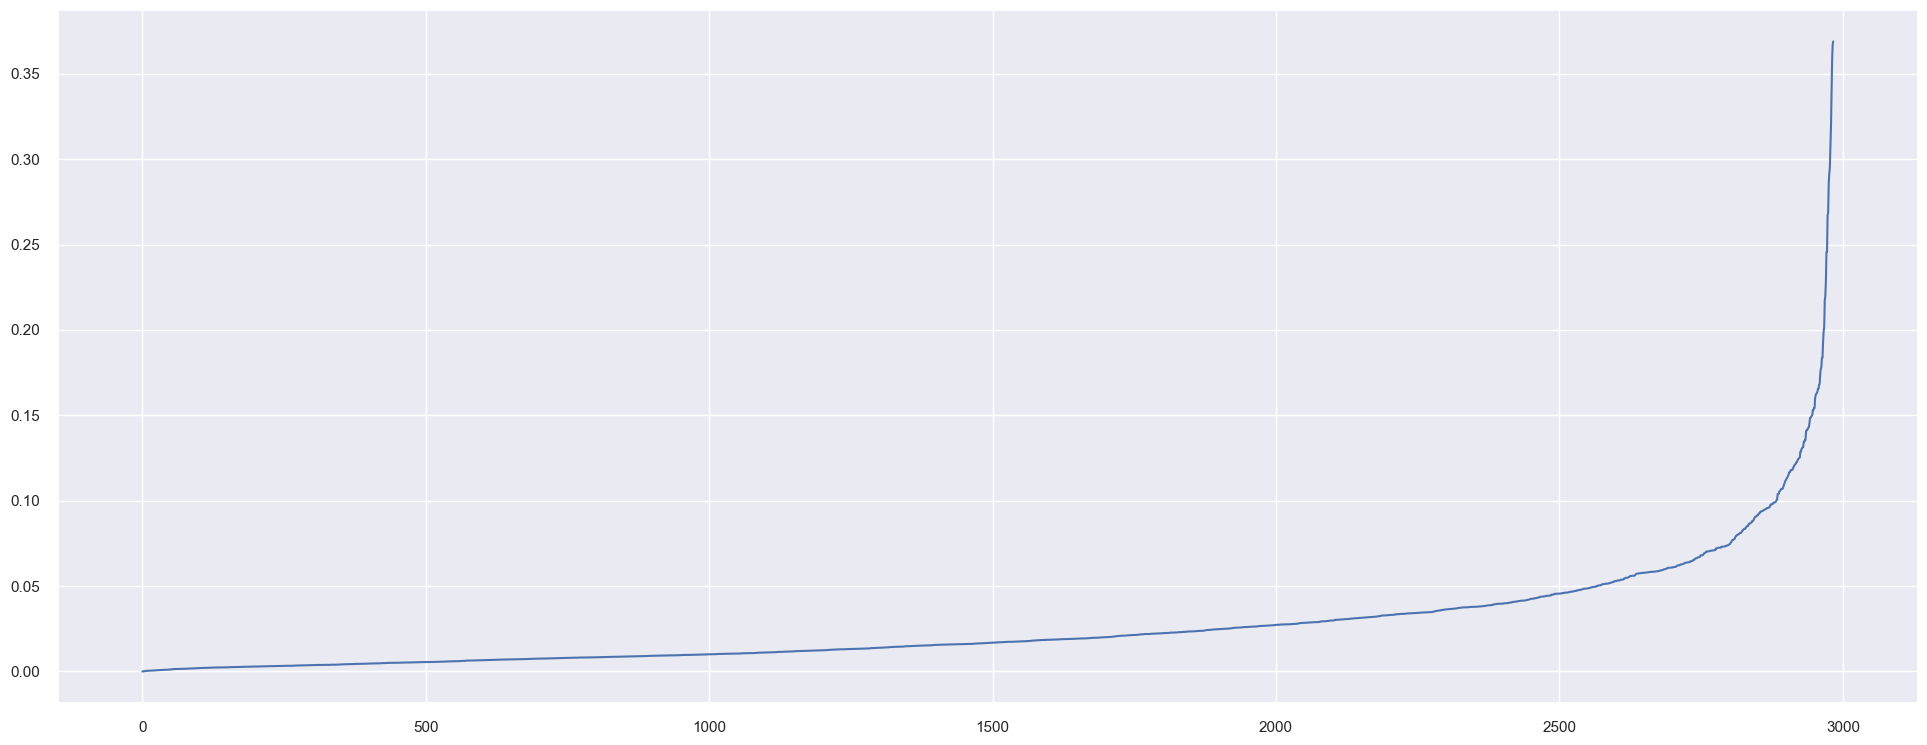

In [174]:
plt.plot( distances );

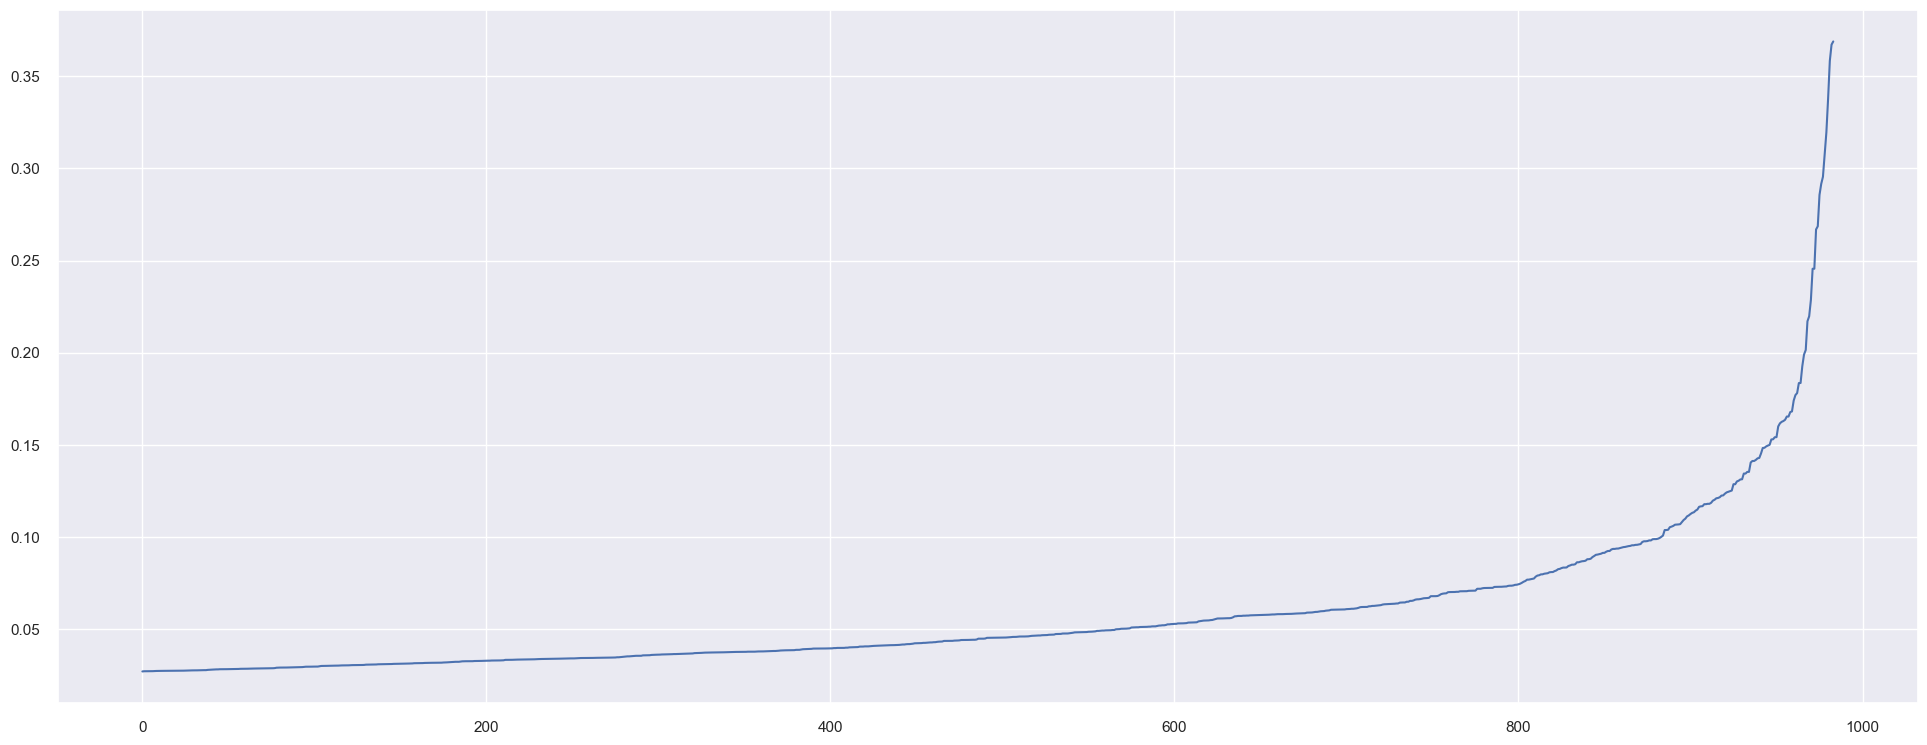

In [175]:
plt.plot( distances[2000:] );

## 7.5. Results

In [176]:
# Model Name | K=2 | K=3 | k=4 | k=5

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hc_list} ).T

df_results.columns = clusters

In [177]:
df_results.style.highlight_max( color= 'lightgreen', axis= 1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.401215,0.495562,0.514534,0.535802,0.581505,0.599155,0.607389,0.653919,0.635912,0.636990,0.639606,0.651355,0.644664,0.651440,0.647545,0.657720,0.670925,0.668776,0.662212,0.674240,0.671793,0.671847,0.635848,0.637086
GMM,0.381985,0.495562,0.508373,0.521923,0.582037,0.548126,0.610053,0.592000,0.651403,0.638775,0.644884,0.640333,0.650040,0.652639,0.659313,0.644165,0.647136,0.630562,0.658963,0.635835,0.657110,0.606216,0.667804,0.606503
HClustering,0.400131,0.477381,0.514674,0.538788,0.582037,0.603152,0.610053,0.653919,0.635912,0.641953,0.644884,0.653862,0.647084,0.653280,0.658650,0.659746,0.671646,0.670103,0.672312,0.668054,0.668804,0.670665,0.670205,0.674019


## 7.6. Silhouette Analysis

For k= 2, Silhouette Score: 0.48343737087484084
For k= 3, Silhouette Score: 0.5020807975333929
For k= 4, Silhouette Score: 0.2825382210708827
For k= 5, Silhouette Score: 0.26779364144318574
For k= 6, Silhouette Score: 0.27992612621660556
For k= 7, Silhouette Score: 0.28390836574442424


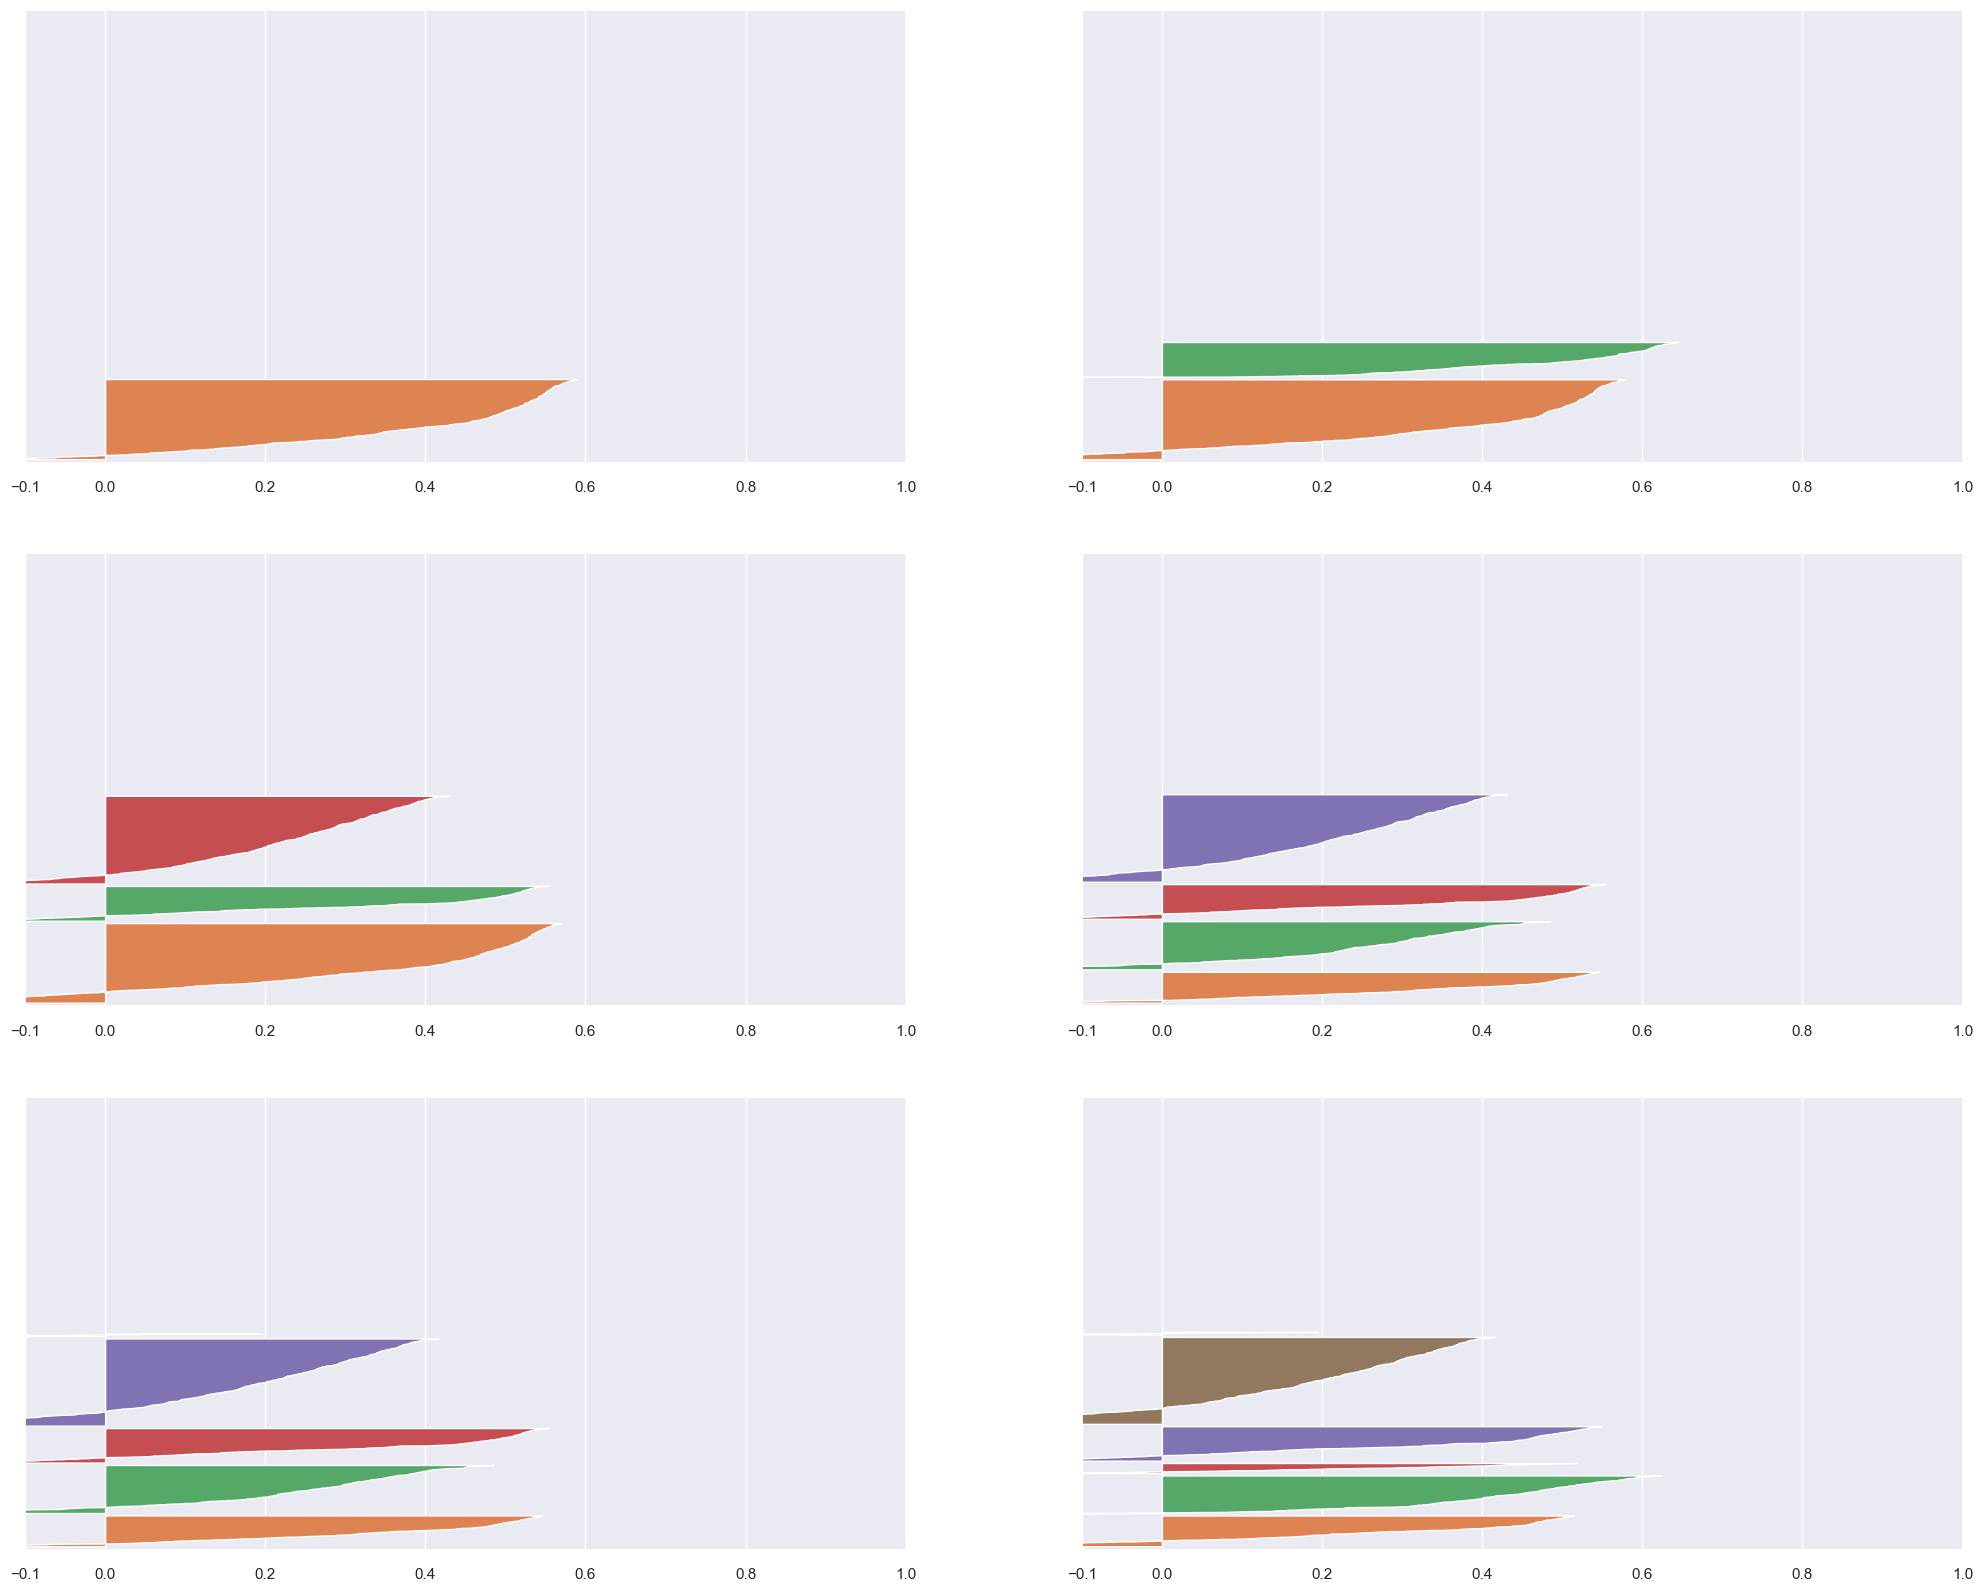

In [91]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + (k+1) * 10 ] )
    
    # model definition and training
    hc_model = hc.linkage( X, 'ward')

    # model predict
    labels = hc.fcluster( hc_model, k, criterion= 'maxclust' )

    # model performance
    ss = mt.silhouette_score( X, labels, metric= 'euclidean' )
    print( f'For k= {k}, Silhouette Score: {ss}')

    samples_ss_values = mt.silhouette_samples( X, labels )

    y_lower = 10

    for i in range( k ):
        # select clusters
        ith_samples_ss_values = samples_ss_values[ labels == i ]

        # sort values
        ith_samples_ss_values.sort()

        # size clusters
        size_cluster_i = ith_samples_ss_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap( 'Spectral' )
        color = cmap( i/k )

        # plot
        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper), 0, ith_samples_ss_values )
        
        y_lower = y_upper + 15
    
    ax[q-1, mod].set_yticks( [] )
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1] )

## 7.7. WSS - Within-Cluster Sum of Square

In [94]:
# Quanto mais próximo de 1, melhor a clusterização ( clusters concentrados e distantes entre si)
# Quanto mais próximo de -1, pior a clusterização ( clusters próximos ou sobrepondo entre si)

In [92]:
# kmeans = KElbowVisualizer( c.KMeans(), k=cluster, timings= False)
# kmeans.fit( X )
# kmeans.show();

## 7.8. Silhouette Score

In [94]:
# kmeans = KElbowVisualizer( c.KMeans(), k=cluster, metric = 'silhouette', timings= False)
# kmeans.fit( X )
# kmeans.show();

# 8.0. MODEL TRAINING

## 8.1. Model Final

### 8.1.1 K-Means

In [266]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state= 42)

# model training
kmeans.fit( X )

# clustering
labels_kmeans = kmeans.labels_

In [267]:
# WSS
print(f'WSS Value: {kmeans.inertia_}')

# SS
print(f'SS Value: { mt.silhouette_score( X, labels_kmeans, metric= "euclidean" ) }' )

WSS Value: 28247.099609375
SS Value: 0.6073889136314392


### 8.1.2 GMM

In [304]:
# model definition
k = 8
gmm_model = mx.GaussianMixture( n_components=k, n_init=100, random_state= 42)

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

In [312]:
# SS
print(f'SS Value: { mt.silhouette_score( X, labels, metric= "euclidean" ) }' )

SS Value: 0.5735397338867188


# 9.0. CLUSTER ANALYSIS

In [305]:
df9 = X.copy()

In [306]:
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,7.000337,-9.016847,3
1,12.766449,-2.516786,0
2,7.157575,-9.472236,3
3,-1.607520,15.264236,7
4,-6.623262,6.195890,1


## 9.1. Visualizations Inspection

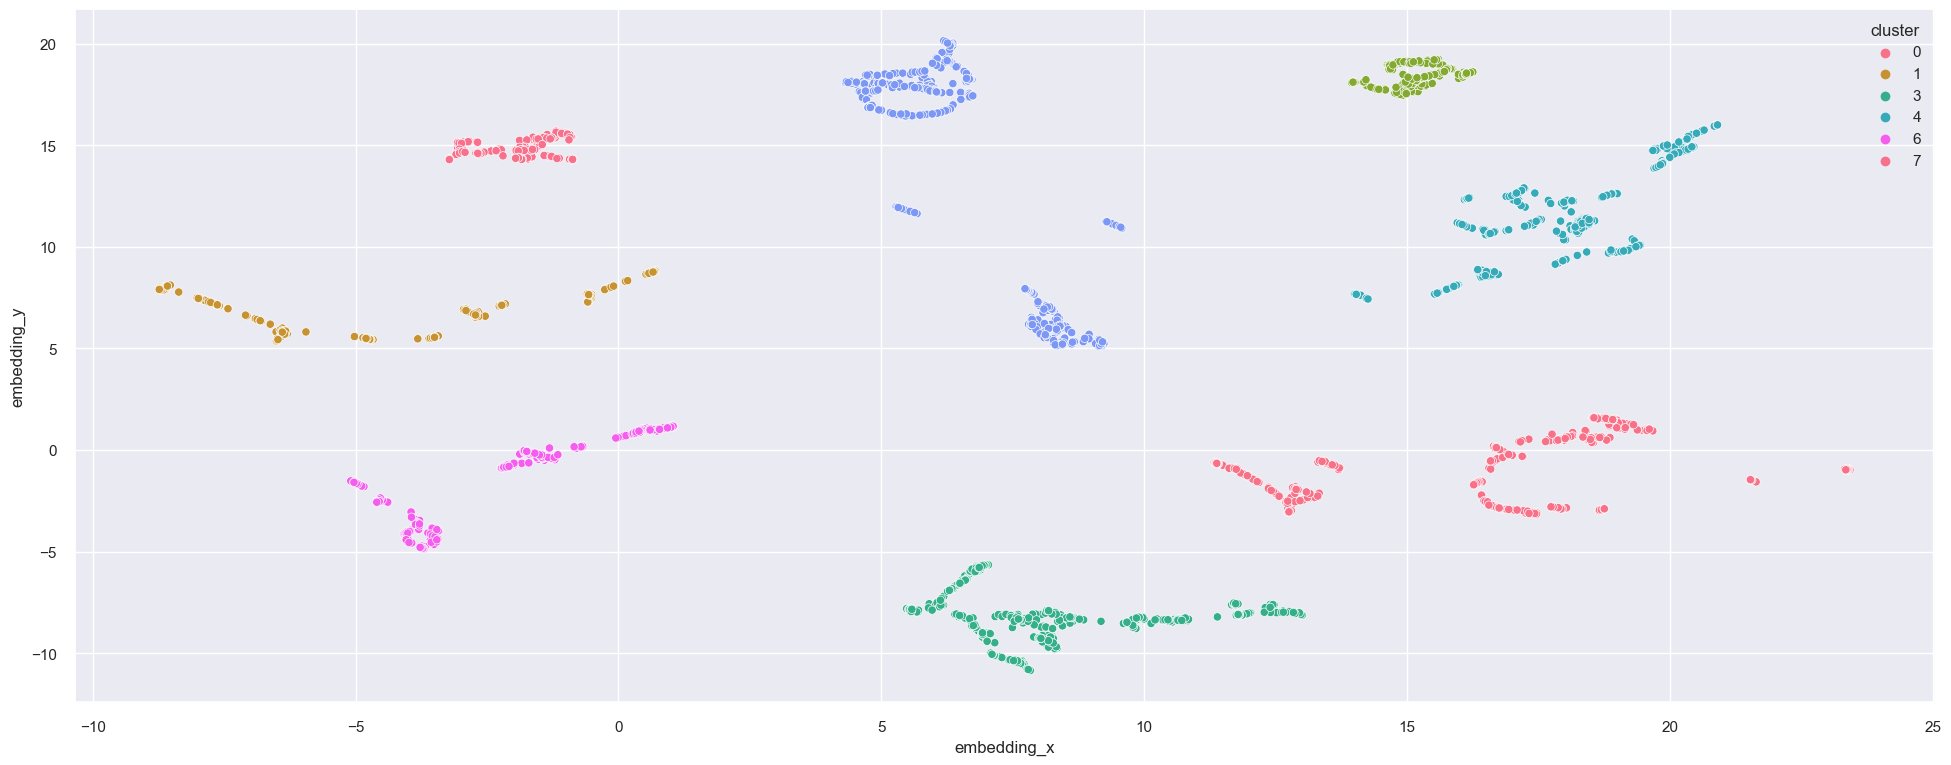

In [307]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue= 'cluster', data= df9, palette= 'husl' );

In [308]:
# fig = px.scatter_3d( df9, x= 'recency_days', y='invoice_no', z='gross_revenue', color= 'cluster' )
# fig.show()

In [309]:
# visualizer = SilhouetteVisualizer( kmeans, colors= 'yellowbrick' )
# visualizer.fit(X)
# visualizer.finalize()

## 9.1.1.  2d Plot

In [310]:
# df_viz = df9.drop( columns = 'customer_id', axis=1)
# sns.pairplot( df_viz, hue= 'cluster' )

## 9.1.2.  UMAP

In [311]:
# reducer = umap.UMAP( n_neighbors=30, random_state=42 )
# embedding = reducer.fit_transform( X )

# # embedding
# df_viz['embedding_x'] = embedding[:, 0]
# df_viz['embedding_y'] = embedding[:, 1]

# # plot UMAP
# sns.scatterplot( data = df_viz, x='embedding_x', y='embedding_y', 
#                 hue='cluster',
#                 palette= sns.color_palette('hls', n_colors= len( df_viz['cluster'].unique() ) ) )

## 9.2. Cluster Profile

In [313]:
df9_2 = df4[cols_selected].copy()
df9_2['cluster'] = labels
df9_2.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3237.54,31.0,172.0,0.029155,36.0,0
2,12583,7281.38,2.0,247.0,0.040323,51.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,7
4,15100,876.00,333.0,3.0,0.073171,22.0,1


In [314]:
# Number of customers
df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() ) * 100

# Average Gross Revenue
df_avg_gross_revenue = df9_2[['cluster', 'gross_revenue']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how= 'inner', on='cluster' )

# Average Recency Days
df_avg_recency = df9_2[['cluster', 'recency_days']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on = 'cluster')

# Average products
df_products = df9_2[['cluster', 'qty_products']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_products, how='inner', on = 'cluster')

# Average Frequency
df_frequency = df9_2[['cluster', 'frequency']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on = 'cluster')

# Average returns
df_returns = df9_2[['cluster', 'qty_returns']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on = 'cluster')

In [315]:
df_cluster.sort_values( 'gross_revenue', ascending= False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,qty_returns
3,3,466,15.616622,9019.845086,22.236052,425.111588,0.095610,157.991416
0,0,505,16.923592,2669.657723,40.857426,142.489109,0.047496,23.744554
5,5,542,18.163539,1871.264852,68.405904,51.280443,0.070664,12.822878
4,4,513,17.191689,1662.388090,55.725146,85.352827,0.053387,11.218324
2,2,190,6.367292,1291.303211,58.131579,59.705263,0.042663,8.700000
7,7,163,5.462466,801.839509,87.742331,27.963190,0.129234,3.699387
6,6,320,10.723861,599.868719,47.909375,13.040625,0.172734,2.587500
1,1,285,9.550938,528.570316,193.389474,15.245614,0.446238,22.361404


## 9.3. First Report

### Cluster 4: Insiders:
 - Quantidade de clientes: 466 (16% dos clientes)
 - Faturamento médio: $ 9.019,00
 - Recencia média: 22 dias
 - Média de produtos comprados: 425 
 - Frequencia de compra: 0,09 compras por dia
 - Média de devoluções: 158


### Cluster 02:
 - Quantidade de clientes: 31 (0,71% dos clientes)
 - Recencia média: 13 dias
 - Média de compras: 53 compras
 - Receita média: U$ 40.583,00 dólares
 
### Cluster 03:
 - Quantidade de clientes: 4335 (99,1 % dos clientes)
 - Recencia média: 92 dias
 - Média de compras: 5 compras
 - Receita média: U$ 1.382,00 dólares

# 10.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [294]:
df10 = df9_2.copy()

## 10.1. MindMap de Hipóteses

## 10.2. Hipóteses de Negócio

### Hipóteses Compra

1. Os clientes do cluster Insiders usam cartão de crédito em 80% das compras. 
2. Os clientes do cluster Insiders possuem um ticket médio de 10% aima do cluster More Products.
3. Os clientes do cluster Insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster Insiders possuem um volume de compra (produtos) acima de 10% do total de compras.**
5. **Os clientes do cluster Insiders possuem um volume de compra (faturamento) acima de 10% do total de compras.**
6. **Os clientes do cluster Insiders tem um numero de devoluções abaixo da média do total de clientes.**

### Hipóteses Cliente

1. 60% dos clientes do cluster Insiders possuem estado civil casado.
2. 10% dos clientes do cluster Insiders tem idade entre 24-35 anos.
3. 40% das localidades de entrega do cluster Insiders estão num raio de 50km.
4. 5% dos clientes do cluster Insiders recebem mais de 100mil dólares anualmente.
5. 90% dos clientes do cluster Insiders tem ensino superior completo.

### Hipóteses Produto

1. 30% de todos os produutos em pacotes grandes são comprados pelos clientes do Insiders.
2. A mediana dos preços dos produtos comprados pelos clientes Insiders é 10% maior que a dos demais clientes
3. O percentil do gmv pelos clientes Insiders.
4. O peso médio dos produtos comprados pelos clientes Insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes Insiders é menor do que 15 dias.

## 10.3. Priorização das Hipóteses

**HIPÓTESES COMPRA**
1. Os clientes do cluster Insiders possuem um volume de compra (produtos) acima de 10% do total de compras.
2. Os clientes do cluster Insiders possuem um volume de compra (faturamento) acima de 10% do total de compras.
3. Os clientes do cluster Insiders tem um numero de devoluções abaixo da média do total de clientes.

**HIPÓTESES CLIENTE**

**HIPÓTESES PRODUTO**
1. A mediana dos preços dos produtos comprados pelos clientes Insiders é 10% maior que a dos demais clientes.
2. O percentil do gmv pelos clientes Insiders.


## 10.4. Validação das Hipóteses

### H1. Os clientes do cluster Insiders possuem um volume de compra (produtos) acima de 10% do total de compras.
**Verdadeiro:** O cluster Insiders possuem um volume de produtos de 54%.

In [316]:
df10.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3237.54,31.0,172.0,0.029155,36.0,6
2,12583,7281.38,2.0,247.0,0.040323,51.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,0
4,15100,876.00,333.0,3.0,0.073171,22.0,5


In [317]:
# qntd produtos cluster Insiders
qntd_sales_insiders = df10.loc[ df10['cluster'] == 4, 'qty_products'].sum()

# qntd produtos total
qntd_sales_total = df10['qty_products'].sum()

# porcentagem vendas insiders
print( f'Sales Insiders: {100 * qntd_sales_insiders / qntd_sales_total:.2f}%')

Sales Insiders: 54.12%


### H2. Os clientes do cluster Insiders possuem um volume de compra (faturamento) acima de 10% do total de compras.
**Verdadeiro:** O cluster Insiders possuem um volume de faturamento de 52%.

In [318]:
# faturamento cluster Insiders
gmv_insiders = df10.loc[ df10['cluster'] == 4, 'gross_revenue'].sum()

# faturamento total
gmv_total = df10['gross_revenue'].sum()

# porcentagem faturamento insiders
print( f'Gross Revenue Insiders: {100 * gmv_insiders / gmv_total:.2f}%')

Gross Revenue Insiders: 51.66%


### H3. Os clientes do cluster Insiders tem um numero de devoluções abaixo da média do total de clientes.
**Falso:** O cluster Insiders possuem média de devolução acima da média.

In [319]:
# média devolução Insiders
returns_insiders = df10.loc[ df10['cluster'] == 4, 'qty_returns'].mean()

# média devolução total
returns_total = df10['qty_returns'].mean()

print(f'Insiders Returns: {returns_insiders:.2f}')
print(f'Total Returns: {returns_total:.2f}')

Insiders Returns: 157.99
Total Returns: 36.12


### H4. A mediana dos preços dos produtos comprados pelos clientes Insiders é 10% maior que a dos demais clientes.
**Verdadeiro:** A mediana do cluster Insiders tem gmv 276% maior que o restante 

In [320]:
# mediana gmv insiders
median_gmv_insiders = df10.loc[ df10['cluster'] == 4, 'gross_revenue'].median()

# mediana gmv total
median_gmv_total = df10.loc[:, 'gross_revenue'].median()

# porcentagem do insiders sobre o total
median_gmv_diff = ((median_gmv_insiders - median_gmv_total) / median_gmv_total) * 100

print( f'Insiders gmv tem mediana {median_gmv_diff :.2f}% maior que restante' )

Insiders gmv tem mediana 276.43% maior que restante


### H5. O gmv dos clientes Insiders estão concentrados no 3º quartil.
**Falso:** 

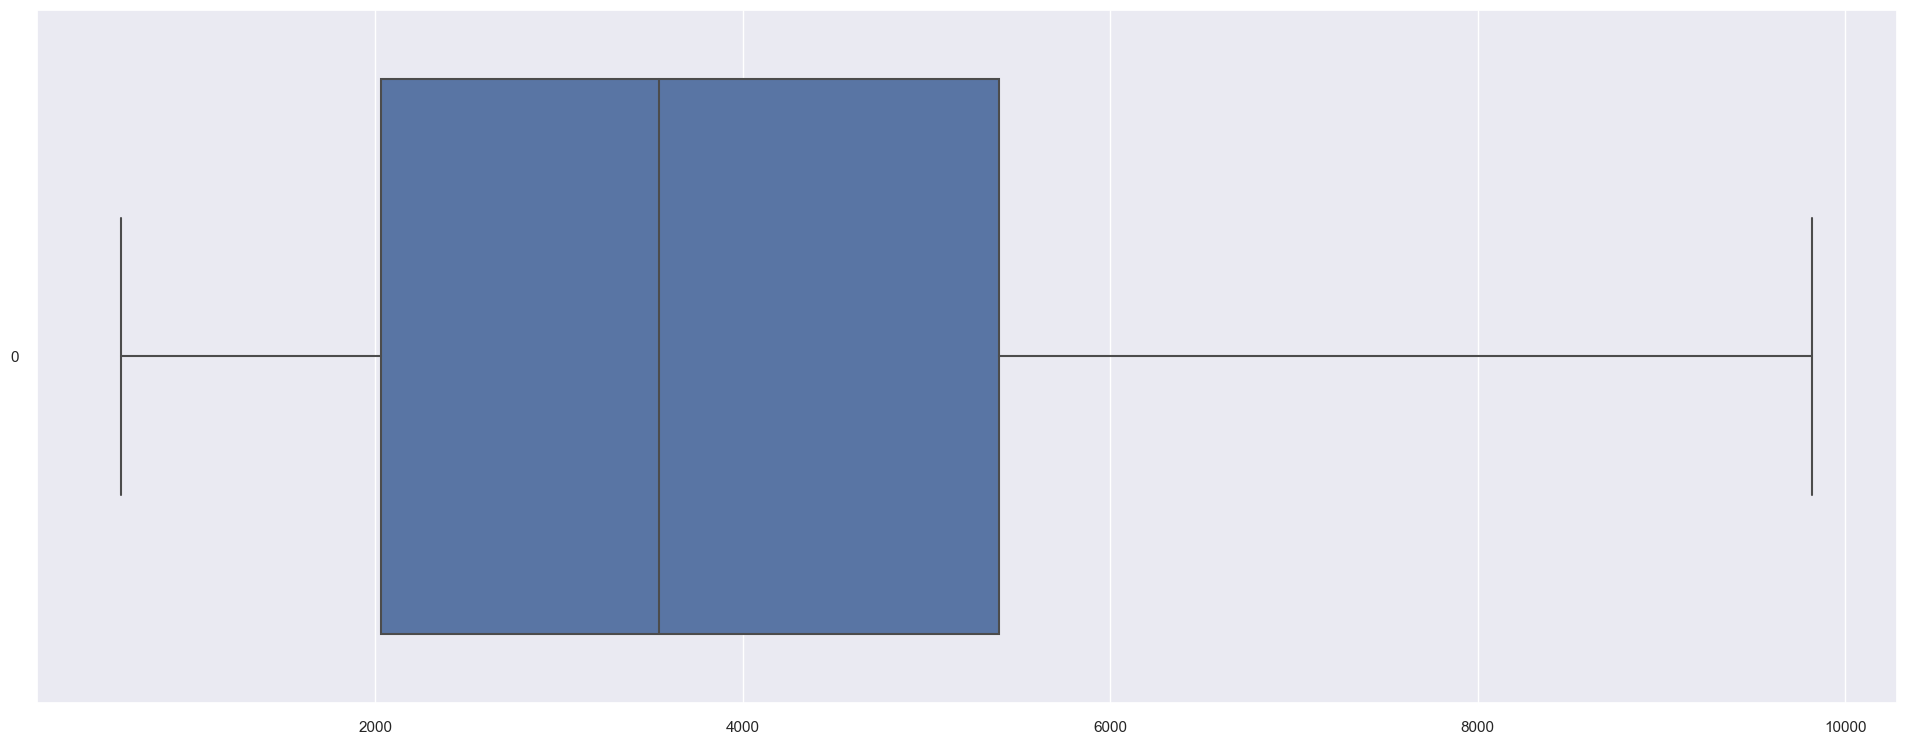

In [321]:
df_aux = df10[ (df10['cluster'] == 4) & (df10['gross_revenue'] < 10000) ]
sns.boxplot( df_aux['gross_revenue'], orient= 'h');

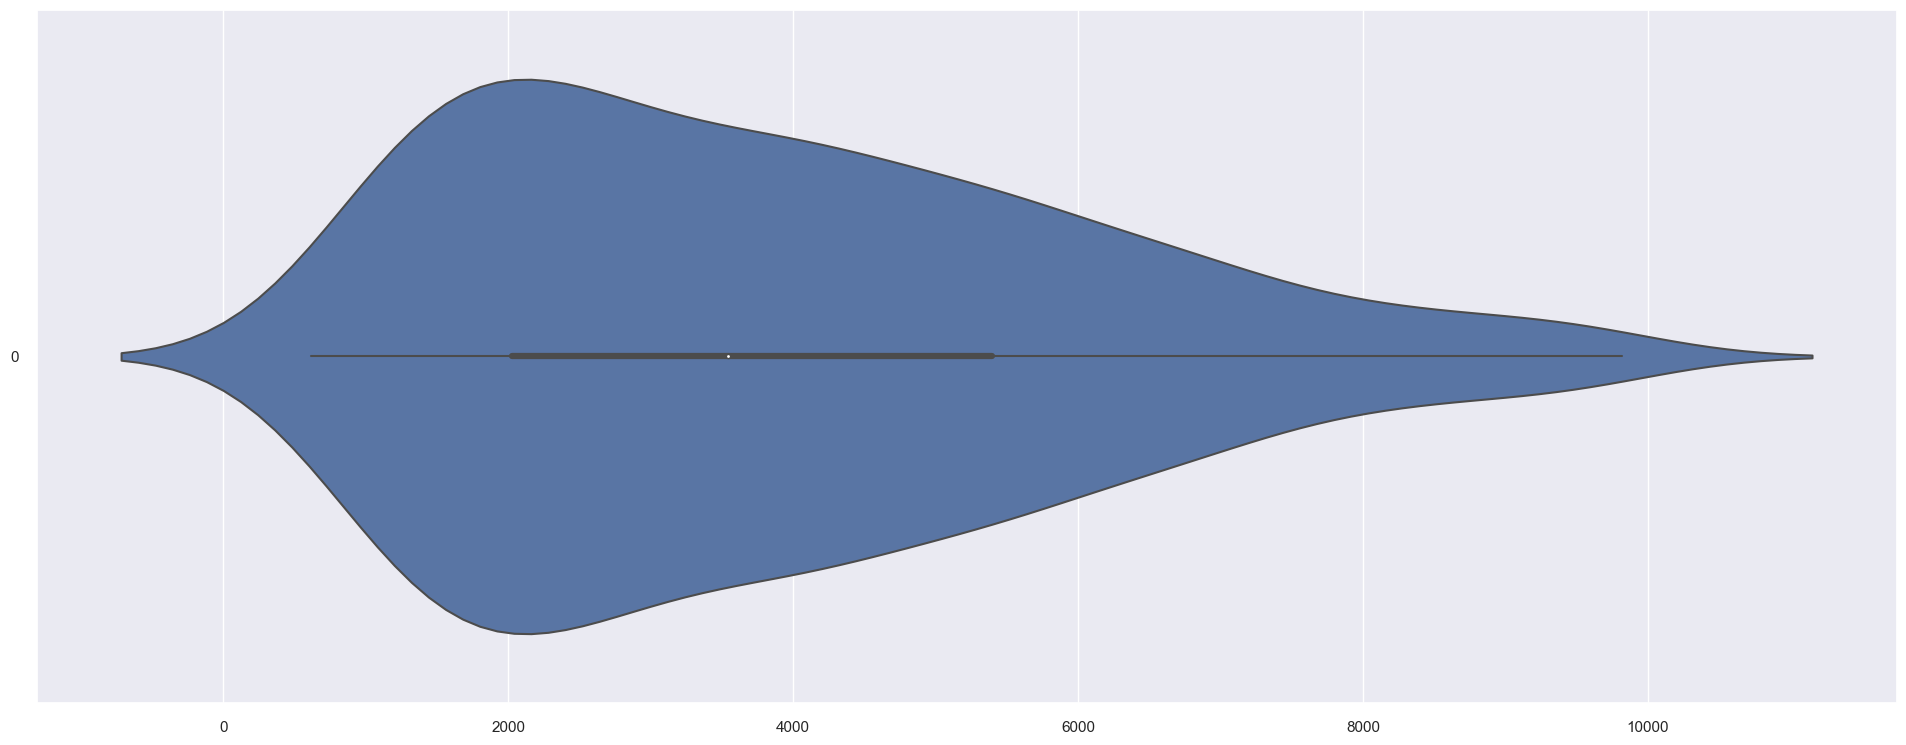

In [322]:
df_aux = df10[ (df10['cluster'] == 4) & (df10['gross_revenue'] < 10000) ]
sns.violinplot( df_aux['gross_revenue'], orient= 'h');

## 10.5. Quadro de Respostas

## 10.6. Perguntas de Negócio

### 1 - Quem são as pessoas elegíveis para participar do programa insiders?

In [233]:
df10.loc[ df10['cluster'] == 0, 'customer_id'].head()

0    17850
2    12583
6    14688
8    15311
9    14527
Name: customer_id, dtype: int64

### 2 - Quantos clientes farão parte do grupo?

466 clientes - 16% do total

### 3 - Quais as principais características desse grupo?

 - Quantidade de clientes: 466 (16% dos clientes)
 - Faturamento médio: $ 9.019,00
 - Recencia média: 22 dias
 - Média de produtos comprados: 425 
 - Frequencia de compra: 0,09 compras por dia
 - Média de devoluções: 158


### 4 - Qual a porcentagem de contribuição do faturamento vinda desse grupo?

In [239]:
# faturamento insiders
gmv_insiders = df10.loc[ df10['cluster'] == 0, 'gross_revenue'].sum()

# faturamento total
gmv_total = df10['gross_revenue'].sum()

# porcentagem faturamento insiders
gmv_diff = (( gmv_total - gmv_insiders ) / gmv_total) * 100

print( f'Contribuição faturamento Insiders: { gmv_diff :.2f}%')

Contribuição faturamento Insiders: 48.34%


### 5 - Qual a expectativa de faturamento desse grupo para os próximos meses?

### 6 - Quais as condições para uma pessoa ser elegível ao insiders?

### 7 - Quais as condições para uma pessoa ser removida do insiders?

### 8 - Qual a garantia de que o programa insiders é melhor que o restante da base?

### 9 - Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 11.0. DEPLOY TO PRODUCTION